In [1]:
import pickle
import time
from pathlib import Path

import pandas as pd
import optuna
import lightgbm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.dummy import DummyClassifier

SEED = 123
BASELINE_RATIO = 0.2

# Let's get the dataset

We are retrieving the dataset from the file created by the `Data Processing.ipynb` notebook.

In [2]:
df = pd.read_csv('dataset_rw.csv')
for dt_col in ['opp_estimated_close_date', 'CreatedDate', 'first_created_date']:
    df[dt_col] = pd.to_datetime(df[dt_col])
print(f"{df.shape=}")
df.head()

df.shape=(160311, 137)


,Unnamed: 0,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,...,n_recipients__tc__x,mean_n_recipients__tc__x,n_recipients__fo__x,mean_n_recipients__fo__x,n_recipients__me__x,mean_n_recipients__me__x,first_created_date,CreatedDate__fq,opp_estimated_close_date__fq,target
0,0,0063000000YvrLnAAJ,2022-11-30,False,2021-10-12,0.0,0.0,0.0,0.0,3.0,...,3.0,1.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q2,0
1,1,0061300001ADuHtAAL,2022-08-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q1,0
2,2,0061300001B0qRQAAZ,2022-07-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q1,0
3,3,0061300001IbZXCAA3,2023-02-28,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q3,0
4,4,0061300001KvHGxAAN,2022-11-08,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q2,0


In [3]:
df.describe()

,Unnamed: 0,opp_estimated_close_date,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,owner_included__tc,duration_in__tc,...,n_recipients__fc__x,mean_n_recipients__fc__x,n_recipients__tc__x,mean_n_recipients__tc__x,n_recipients__fo__x,mean_n_recipients__fo__x,n_recipients__me__x,mean_n_recipients__me__x,first_created_date,target
count,160311.000000,160311,160311,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,...,160311.000000,160311.000000,160311.00000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311,160311.000000
mean,80155.000000,2022-11-11 12:25:56.764039680,2022-07-09 11:02:26.123472896,0.043260,0.029911,4.420707,0.152441,0.100162,0.056303,55.555464,...,16.938307,0.960570,38.68475,1.309816,4.747360,0.824527,8.884325,2.032249,2022-03-06 09:38:55.482904832,0.050146
min,0.000000,2021-10-12 00:00:00,2021-10-12 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-10-12 00:00:00,0.000000
25%,40077.500000,2022-07-25 00:00:00,2022-02-17 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-10-12 00:00:00,0.000000
50%,80155.000000,2022-11-03 00:00:00,2022-06-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-12-09 00:00:00,0.000000
75%,120232.500000,2023-03-10 00:00:00,2022-11-10 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.142857,23.00000,1.571429,0.000000,0.000000,0.000000,0.000000,2022-07-06 00:00:00,0.000000
max,160310.000000,2023-09-08 00:00:00,2023-09-08 00:00:00,21.000000,21.000000,25935.000000,696.000000,37.000000,37.000000,108647.000000,...,2575.000000,24.000000,2786.00000,124.499999,632.000000,281.999997,1446.000000,275.999997,2023-08-23 00:00:00,1.000000
std,46277.943839,NaN,NaN,0.369076,0.290704,126.746176,3.637546,0.566949,0.396776,680.837500,...,93.709678,2.049748,131.82972,2.684039,35.887491,8.016977,53.876738,9.143741,NaN,0.218247


In [4]:
# reduce N because the stats are not impacted
df = df[df.CreatedDate.dt.day.isin([1, 7, 13, 19, 25])]
df.describe()

,Unnamed: 0,opp_estimated_close_date,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,owner_included__tc,duration_in__tc,...,n_recipients__fc__x,mean_n_recipients__fc__x,n_recipients__tc__x,mean_n_recipients__tc__x,n_recipients__fo__x,mean_n_recipients__fo__x,n_recipients__me__x,mean_n_recipients__me__x,first_created_date,target
count,26415.000000,26415,26415,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,...,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415,26415.000000
mean,79860.546091,2022-11-10 22:50:59.080068352,2022-07-08 10:07:20.749574400,0.042476,0.029756,3.840356,0.139239,0.102328,0.056975,57.159947,...,16.779708,0.958443,38.455537,1.305769,4.729510,0.822812,8.818361,2.029526,2022-03-05 15:30:17.376490496,0.050085
min,289.000000,2021-10-13 00:00:00,2021-10-13 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-10-12 00:00:00,0.000000
25%,40603.500000,2022-07-20 00:00:00,2022-02-19 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-10-12 00:00:00,0.000000
50%,79810.000000,2022-11-01 00:00:00,2022-06-19 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-12-08 00:00:00,0.000000
75%,119588.500000,2023-03-08 00:00:00,2022-11-07 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.142857,23.000000,1.571429,0.000000,0.000000,0.000000,0.000000,2022-07-06 00:00:00,0.000000
max,160308.000000,2023-09-08 00:00:00,2023-09-07 00:00:00,12.000000,11.000000,5161.000000,172.000000,37.000000,37.000000,60450.000000,...,2307.000000,24.000000,2668.000000,83.333333,632.000000,281.999997,1434.000000,275.999997,2023-08-23 00:00:00,1.000000
std,46363.169096,NaN,NaN,0.359426,0.278084,78.639930,2.136550,0.584251,0.416007,687.800043,...,92.740013,2.050190,131.160686,2.660168,35.854423,8.033803,53.366603,9.136328,NaN,0.218125


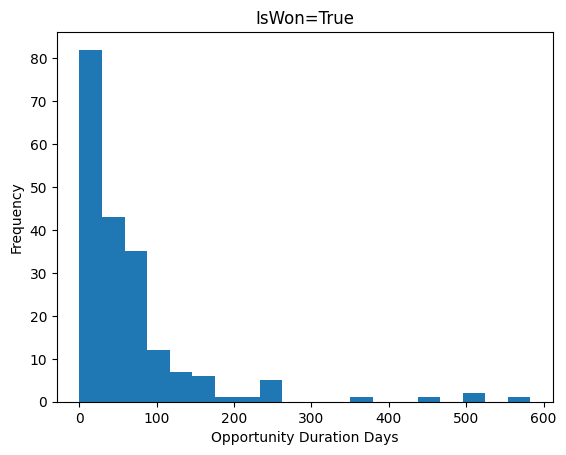

count    197.000000
mean      65.182741
std       85.618858
min        0.000000
25%       17.000000
50%       38.000000
75%       76.000000
max      583.000000
Name: duration, dtype: float64


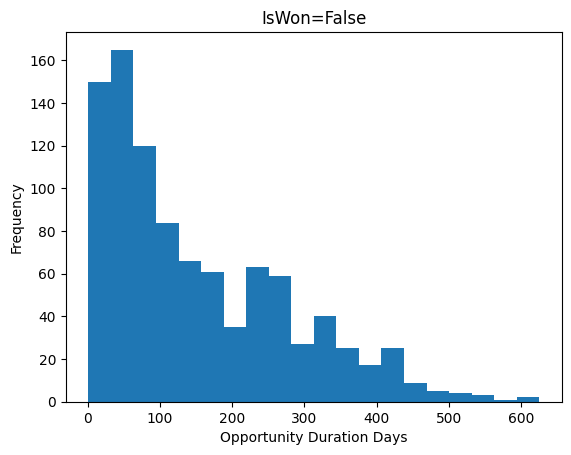

count    961.000000
mean     152.177940
std      126.689954
min        1.000000
25%       48.000000
50%      110.000000
75%      240.000000
max      625.000000
Name: duration, dtype: float64


In [5]:
df = df.sort_values('CreatedDate', ascending=True)

# plot opportunity duration distributions for each opportunity
for won in [True, False]:
    df_won = df[df.IsWon == won].copy()
    # keep first mention of the opportunity in the dataset
    df_won_unique = df_won.drop_duplicates('OpportunityId').copy() 
    df_won_unique.loc[:, 'duration'] = (df_won_unique['opp_estimated_close_date'] -
                                        df_won_unique['first_created_date']).dt.days
    df_won_unique['duration'].plot.hist(bins=20, title=f'IsWon={won}')
    plt.xlabel('Opportunity Duration Days')
    plt.show()
    print(df_won_unique['duration'].describe())

Based on the above, lost opportunities tend to last much longer (mean=151 days vs 57 days for won opportunities). Thus, the current duration of the opportunity might also be a strong predictor of whether it will close successfully or not.


<Axes: xlabel='Current Duration', ylabel='Frequency'>

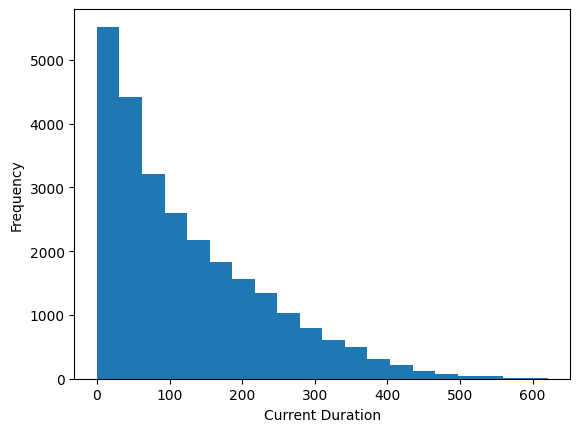

In [6]:
df['current_duration'] = (df['CreatedDate'] - df['first_created_date']).dt.days
df['current_duration'].plot.hist(bins=20, xlabel='Current Duration')

Let's define some training columns for the baseline model. We will start with the 7-day rolling window features representing the number of communications for inbound, outbound, indirect emails as well as meetings as well as the expanding feature of outbound emails.

In [7]:
train_columns = ['current_duration'] + [x for x in list(df) if ((x.startswith('n__') or x.startswith('mean_')) and x.count('_fo') == 0)]
train_columns

['current_duration',
 'n__fc',
 'n__tc',
 'n__me',
 'n__fc__rw7',
 'n__tc__rw7',
 'n__me__rw7',
 'mean_duration_in__fc__rw7',
 'mean_duration_in__tc__rw7',
 'mean_duration_in__me__rw7',
 'mean_owner_included__fc__rw7',
 'mean_owner_included__tc__rw7',
 'mean_owner_included__me__rw7',
 'mean_n_recipients__fc__rw7',
 'mean_n_recipients__tc__rw7',
 'mean_n_recipients__me__rw7',
 'n__fc__rw30',
 'n__tc__rw30',
 'n__me__rw30',
 'mean_duration_in__fc__rw30',
 'mean_duration_in__tc__rw30',
 'mean_duration_in__me__rw30',
 'mean_owner_included__fc__rw30',
 'mean_owner_included__tc__rw30',
 'mean_owner_included__me__rw30',
 'mean_n_recipients__fc__rw30',
 'mean_n_recipients__tc__rw30',
 'mean_n_recipients__me__rw30',
 'n__fc__rw90',
 'n__tc__rw90',
 'n__me__rw90',
 'mean_duration_in__fc__rw90',
 'mean_duration_in__tc__rw90',
 'mean_duration_in__me__rw90',
 'mean_owner_included__fc__rw90',
 'mean_owner_included__tc__rw90',
 'mean_owner_included__me__rw90',
 'mean_n_recipients__fc__rw90',
 'mean_n

The code below shows the distribution of the positive classes across different levels of data aggregation. 18.9% of opportuntiies are won at some point. Less so, only 8% of opportunity-quarters are positive. This means that opportunities, on average, even if won eventually, are won after several quarters of being open (being a negative class). 

Finally, only 5% of the opportunity-days represent positive classes. This means that there will be a high class imbalance that we will need to account for.

In [8]:
# this column shows the % of the opportunities closed successfully
p_opp_won = df.groupby(['OpportunityId'], as_index=False).agg(
    {'target': 'max'}).target.astype(int).mean()
p_opp_fq_won = df.groupby(
    ['OpportunityId', 'CreatedDate__fq'], as_index=False
).agg({'target': 'first'}).target.astype(int).mean()
# and the number of rows that have target == 1
p_samples_won = df.target.mean()

print(f"% of Opportunities Won: {p_opp_won*100:.2f}%")
print(f"% of Opportunity-FQs Won: {p_opp_fq_won*100:.2f}%")
print(f"% of Opportunity-Days Won: {p_samples_won*100:.2f}%")

% of Opportunities Won: 17.01%
% of Opportunity-FQs Won: 7.29%
% of Opportunity-Days Won: 5.01%


The below cell groups all opportunity-days by fiscal quarter and opportunity identifier (target for each group is the same). This is used to split the data into training and test sets - we should avoid putting data points from the same opportunity-quarter into two datasets as it might trick the model.

Additionally, after obtaining training the test sets, we further cut the training set to speed up the baseline model training process. The test set is further split into test and validation sets.

The final distribution of data is as follows:
- training set: 60% of all opportunity-quarters
- test set: 20% of all opportunity-quarters
- validation set: 20% of all opportunity-quarters

All opportunity-quarters are split in a stratified way with the outcome variable in mind to ensure that the class imbalance problem doesn't propagate further.

In [9]:
# this identifies unique sets of Opportunities and FQs, because the target 
# is the same for each pair (Opp, FQ)
unique_params = df[['CreatedDate__fq', 'OpportunityId', 'target']].drop_duplicates()

# first we split the whole dataset into what will be test and train, equally, with regards to target
train_params, test_params = train_test_split(unique_params, 
                                             test_size=0.4, 
                                             stratify=unique_params['target'], 
                                             random_state=SEED)

# taking 0.4*0.5 = 0.2 for test and 0.4*0.5=0.2 for validation
test_params, val_params = train_test_split(test_params, 
                                           test_size=0.5, 
                                           stratify=test_params['target'], 
                                           random_state=SEED)

The following cell assigns opportunity-days to train, test, or validation sets based on their identifiers and quarters.

In [10]:
train = []
test = []
val = []

df_shuffled = df.sample(frac=1, random_state=SEED)
grouped = df_shuffled.groupby(['OpportunityId', 'CreatedDate__fq'])

train_params = set(list(train_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
test_params = set(list(test_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
val_params = set(list(val_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))


for name, group in grouped:
    if name in train_params:
        train.append(group)
    elif name in test_params:
        test.append(group)
    elif name in val_params:
        val.append(group)

train = pd.concat(train)
test = pd.concat(test)
val = pd.concat(val)


In [11]:
#print(train[train_columns].shape, test[train_columns].shape, val[train_columns].shape)
print(f"Opportunity-days won in df: {df.target.mean():.4f}")
print(f"Opportunity-days won in train: {train.target.mean():.4f}")
print(f"Opportunity-days won in test: {test.target.mean():.4f}")
print(f"Opportunity-days won in test: {val.target.mean():.4f}")

Opportunity-days won in df: 0.0501
Opportunity-days won in train: 0.0490
Opportunity-days won in test: 0.0532
Opportunity-days won in test: 0.0501


From the output above, we can see that the number ratio of "won" rows is the relatively similar between train, test, and the whole dataset. Before using stratified sampling, it used to be 0.038 for train (10 times smaller than the "true" value!)

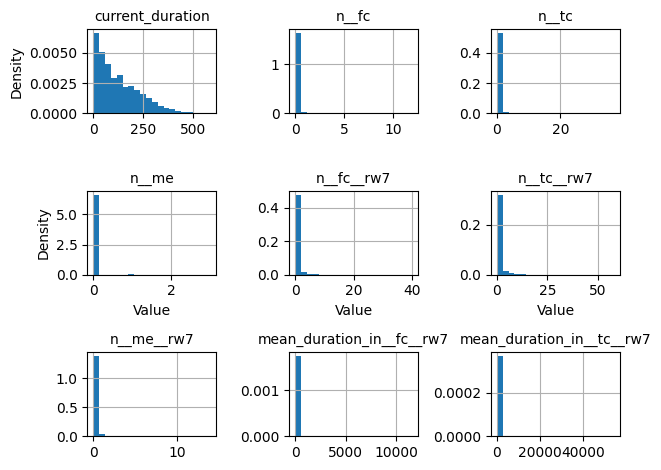

In [12]:
fig, ax = plt.subplots(3, 3)
max_show = min(len(ax.flatten()), len(train_columns))
pl = train[train_columns[:max_show]].hist(density=True, ax=ax.flatten()[:max_show], bins=20)
ax[1][0].set_xlabel('Value')
ax[1][1].set_xlabel('Value')
ax[1][2].set_xlabel('Value')
ax[0][0].set_ylabel('Density')
ax[1][0].set_ylabel('Density')
[x.title.set_size(10) for x in pl.ravel()]
plt.tight_layout()
plt.show()

Since we are using SVCs, it's a good practice to normalize the data. For that, we will take the log of data to reduce its skewness attributable to the high sparsity. Then, we rescale the data to a smaller range of values to optimize for the SVC's speed. We train the scaler on train data but then apply it to the testing and validation sets as well. Final data distributions for train set are provided below

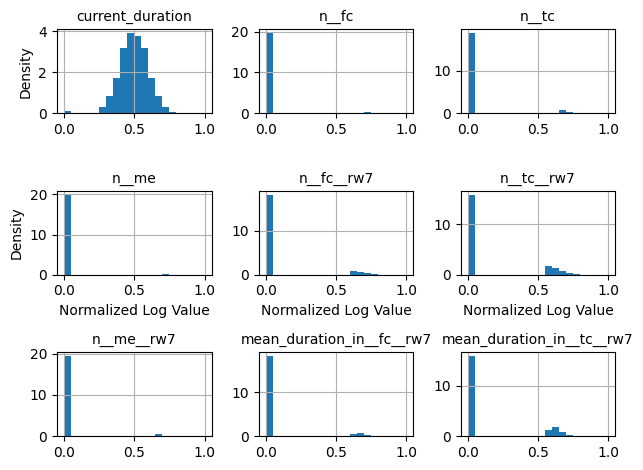

In [13]:
scaler = None
for dataset in [train, test, val]:
    # for feature in train_columns:
    #     dataset[feature] = np.log1p(dataset[feature])

    # this condition will be entered only for the train set
    if not scaler:
        scaler = Pipeline(
            (
                ('quantile', QuantileTransformer(n_quantiles=200, output_distribution='normal', random_state=SEED)),
                ('minmax', MinMaxScaler(feature_range=(0,1)))
            )
        )
        scaler.fit(dataset[train_columns])
        dataset[train_columns] = scaler.transform(dataset[train_columns])

        fig, ax = plt.subplots(3, 3)
        max_show = min(len(ax.flatten()), len(train_columns))
        pl = train[train_columns[:max_show]].hist(density=True, ax=ax.flatten()[:max_show], bins=20)
        
        ax[1][0].set_xlabel('Normalized Log Value')
        ax[1][1].set_xlabel('Normalized Log Value')
        ax[1][2].set_xlabel('Normalized Log Value')
        ax[0][0].set_ylabel('Density')
        ax[1][0].set_ylabel('Density')
        [x.title.set_size(10) for x in pl.ravel()]
        plt.tight_layout()
        plt.show()
    else:
        dataset[train_columns] = scaler.transform(dataset[train_columns])
    



Now, let's add some synthetical samples to the train data to decrease the imbalance. We use SMOTE for this.

In [14]:
# let's augment the train dataset a bit and generate more positive samples :)
smote = SMOTE(sampling_strategy=1/9, random_state=SEED)
train, target = smote.fit_resample(train[train_columns], train.target)

train['target'] = target


In [15]:
print(f"{train[train_columns].shape}", f"{test[train_columns].shape}")
print(f"Opportunity-days won in train: {train.target.mean():.3f}")
print(f"Opportunity-days won in test: {test.target.mean():.3f}")

(16728, 52) (5377, 52)
Opportunity-days won in train: 0.100
Opportunity-days won in test: 0.053


In [16]:
def get_metrics(y_true, y_pred, y_proba, sample_weights=None) -> dict:
    metric = dict()
    metric['f1'] = metrics.f1_score(y_true, y_pred)
    metric['precision'] = metrics.precision_score(y_true, y_pred)
    metric['recall'] = metrics.recall_score(y_true, y_pred)
    metric['matt_score'] = metrics.matthews_corrcoef(y_true, y_pred)
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
    metric['pr_auc'] = metrics.auc(recall, precision)
    metric['roc_auc'] = metrics.roc_auc_score(y_true, y_pred)
    metric['log_loss'] = metrics.log_loss(y_true, y_proba)
    metric['bas'] = metrics.balanced_accuracy_score(y_true, y_pred)
    return metric

def get_report(metrics_dict, prefix=""):
    for key, value in metrics_dict.items():
        tabs = '\t\t' if len(key) <= 6 else '\t'
        print(f"{prefix}\t{key}:{tabs}{value:.4f}")

def get_trial_info(study):
    study_data = []
    for t in study.get_trials():
        study_data.append(t.params | {'metric': t.value, 'trial': t.number})
    return pd.DataFrame(study_data)

def get_best_roc_threshold(true, proba):
    fpr, tpr, thresholds = metrics.roc_curve(true, proba)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print(f'Best Threshold={thresholds[ix]}')
    return thresholds[ix]

In [17]:
# specify loss functions for training and direction to optimize

LOSS_FUNCTION = 'log_loss'
DIRECTION = 'minimize'

In [18]:
def objective_for_stratified(train_data: pd.DataFrame, val_data, trial: optuna.Trial, get_estimator) -> float:
    """
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    train_data: pd.DataFrame - the train dataset
    val_data: pd.DataFrame - the validation dataset 
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    model, columns = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    splits = 0
    x_train, x_test, y_train, y_test = (train_data[columns], 
                                        val_data[columns], 
                                        train_data.target, 
                                        val_data.target)
        
    model.fit(x_train, y_train)
        
    # generate predictions for the unseen quarter and save it
    y_proba = model.predict_proba(x_test)[:, 1]
    y_pred = model.predict(x_test)
    metrics = get_metrics(y_test, y_pred, y_proba)

    return metrics[LOSS_FUNCTION]


def optimize(train_data, val_data, objective, get_estimator, n_trials, n_jobs=1):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    objective: function - the objective to be minimized
    n_trials: int - the number of model iterations 
    
    Returns
    ------------
    Model - the fitted model object
    """

    # optimize the model on `n_trials`
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction=DIRECTION, sampler=sampler)
    study.optimize(
        lambda trial: objective(train_data, val_data, trial, get_estimator), 
        n_trials=n_trials, 
        n_jobs=n_jobs,
        timeout=3600,
        )

    # retrieve the best model and fit it
    model, columns = get_estimator(trial=None, params=study.best_params)
    model.fit(train_data[columns], train_data.target)
    return model, columns, study

## Candidate 0: Dummy Classifier

In [19]:
timestamp = int(time.time())

In [20]:
dummy = DummyClassifier(strategy='stratified', random_state=SEED)
dummy.fit(train[train_columns], train.target)
# get predictions 
test['dummy_pred'] = dummy.predict(test[train_columns])
test['dummy_proba'] = dummy.predict_proba(test[train_columns])[:, 1]
train['dummy_pred'] = dummy.predict(train[train_columns])
train['dummy_proba'] = dummy.predict_proba(train[train_columns])[:, 1]
val['dummy_pred'] = dummy.predict(val[train_columns])
val['dummy_proba'] = dummy.predict_proba(val[train_columns])[:, 1]

get_report(get_metrics(train.target, train.dummy_pred, train.dummy_proba), prefix="Dummy Train")
print()
get_report(get_metrics(test.target, test.dummy_pred, test.dummy_proba), prefix="Dummy Test ")
print()
get_report(get_metrics(val.target, val.dummy_pred, val.dummy_proba), prefix="Dummy Val ")

/tmp/ipykernel_261199/4220430930.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['dummy_pred'] = dummy.predict(test[train_columns])
/tmp/ipykernel_261199/4220430930.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['dummy_proba'] = dummy.predict_proba(test[train_columns])[:, 1]
/tmp/ipykernel_261199/4220430930.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

Dummy Train	f1:		0.1023
Dummy Train	precision:	0.1036
Dummy Train	recall:		0.1011
Dummy Train	matt_score:	0.0039
Dummy Train	pr_auc:		0.1472
Dummy Train	roc_auc:	0.5020
Dummy Train	log_loss:	6.3908
Dummy Train	bas:		0.5020

Dummy Test 	f1:		0.0692
Dummy Test 	precision:	0.0535
Dummy Test 	recall:		0.0979
Dummy Test 	matt_score:	0.0005
Dummy Test 	pr_auc:		0.0997
Dummy Test 	roc_auc:	0.5003
Dummy Test 	log_loss:	5.0476
Dummy Test 	bas:		0.5003

Dummy Val 	f1:		0.0728
Dummy Val 	precision:	0.0551
Dummy Val 	recall:		0.1073
Dummy Val 	matt_score:	0.0075
Dummy Val 	pr_auc:		0.1036
Dummy Val 	roc_auc:	0.5051
Dummy Val 	log_loss:	4.9364
Dummy Val 	bas:		0.5051


## Candidate 1: SVC - Support Vector Classifier

In [21]:
svc_trial_config = {
    'suggest_float':
    {
        'C': {'name': 'C', 'low': 1e-3, 'high': 10.0, 'log': True},
        'gamma': {'name': 'gamma', 'low': 0.0001, 'high': 1, 'log': True},
        'coef0': {'name': 'coef0', 'low': -3, 'high': 6}
    },
    'suggest_int':
    {
        'degree': {'name': 'degree', 'low': 1, 'high': 7}
    }
}

for feature in train_columns:
    svc_trial_config['suggest_float'][f'${feature}'] = {'name': f'${feature}', 'low': 0, 'high': 1}

def get_svc_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    columns = []
    if params is None:
        params = {}
        trial_node = svc_trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                if name[0] != '$':
                    params[name] = method(**kwargs)
                else:
                    to_add = method(**kwargs)
                    if to_add < BASELINE_RATIO:
                        columns.append(name[1:])
    else:
        actual_params = {}
        for name, value in params.items():
            if name[0] == '$':
                if value < BASELINE_RATIO:
                    columns.append(name[1:])
            else:
                actual_params[name] = value
        params = actual_params
        
    print(f"{params=}\n{len(columns)=}")
                
    model = SVC(
        kernel='poly',
        tol=2,
        verbose=0,
        random_state=SEED, 
        probability=True,
        class_weight='balanced',  # because of class imbalance
        **params)
    return model, columns

svc, svc_columns, svc_study = optimize(train, val, objective_for_stratified, get_svc_estimator, 70, n_jobs=6)

[I 2024-02-20 08:19:55,842] A new study created in memory with name: no-name-2956e356-1a7b-4427-b2e8-e28bacc4be74


params={'C': 1.4233142053418504, 'gamma': 0.00025668497567672374, 'coef0': -0.3162902343771803, 'degree': 3}
len(columns)=7
params={'C': 0.8579645504373765, 'gamma': 0.000188261716172703, 'coef0': 3.988567179232396, 'degree': 7}
len(columns)=18
params={'C': 0.0959484742549047, 'gamma': 0.0036677169579676055, 'coef0': 5.2404099626319365, 'degree': 5}
len(columns)=9
params={'C': 0.1605956982246544, 'gamma': 0.13859983472416376, 'coef0': 0.9170909723478484, 'degree': 3}
len(columns)=7
params={'C': 0.07782832385075777, 'gamma': 0.008649160933927891, 'coef0': -2.9013616634565618, 'degree': 4}
len(columns)=8
params={'C': 0.01868321322375965, 'gamma': 0.001730148978589578, 'coef0': 0.9842592565194375, 'degree': 7}
len(columns)=13


[I 2024-02-20 08:21:42,130] Trial 3 finished with value: 0.21552200519123335 and parameters: {'C': 0.07782832385075777, 'gamma': 0.008649160933927891, 'coef0': -2.9013616634565618, '$current_duration': 0.002804681465058856, '$n__fc': 0.2624109618867695, '$n__tc': 0.6106729182956053, '$n__me': 0.3951310255778342, '$n__fc__rw7': 0.4992711480157489, '$n__tc__rw7': 0.4183323412313491, '$n__me__rw7': 0.33106201447355754, '$mean_duration_in__fc__rw7': 0.8717442248737964, '$mean_duration_in__tc__rw7': 0.7544307233818478, '$mean_duration_in__me__rw7': 0.8414454416220937, '$mean_owner_included__fc__rw7': 0.7482265639574212, '$mean_owner_included__tc__rw7': 0.3215198952835896, '$mean_owner_included__me__rw7': 0.8270375495881196, '$mean_n_recipients__fc__rw7': 0.7547938147616161, '$mean_n_recipients__tc__rw7': 0.45841900733950836, '$mean_n_recipients__me__rw7': 0.3588364858419588, '$n__fc__rw30': 0.12327495547639167, '$n__tc__rw30': 0.433567803087334, '$n__me__rw30': 0.6693997728432369, '$mean_du

params={'C': 1.0408530538594014, 'gamma': 0.40100658728603694, 'coef0': 0.8422656178116155, 'degree': 6}
len(columns)=10


[I 2024-02-20 08:22:15,384] Trial 0 finished with value: 0.2248556306176898 and parameters: {'C': 1.4233142053418504, 'gamma': 0.00025668497567672374, 'coef0': -0.3162902343771803, '$current_duration': 0.24051873106623256, '$n__fc': 0.5483162995822672, '$n__tc': 0.2583053531746108, '$n__me': 0.8141369550398958, '$n__fc__rw7': 0.2443893874488987, '$n__tc__rw7': 0.7257981179196571, '$n__me__rw7': 0.25420449222167196, '$mean_duration_in__fc__rw7': 0.6932881877495205, '$mean_duration_in__tc__rw7': 0.7204554848363635, '$mean_duration_in__me__rw7': 0.5954003303940498, '$mean_owner_included__fc__rw7': 0.25193477072310444, '$mean_owner_included__tc__rw7': 0.7033798007523973, '$mean_owner_included__me__rw7': 0.8788202542073624, '$mean_n_recipients__fc__rw7': 0.08841607283596231, '$mean_n_recipients__tc__rw7': 0.45866546424642096, '$mean_n_recipients__me__rw7': 0.3534236762400652, '$n__fc__rw30': 0.9085587922932338, '$n__tc__rw30': 0.9525842958890417, '$n__me__rw30': 0.8249926055985165, '$mean_d

params={'C': 8.0780349456368, 'gamma': 0.0034781166700685396, 'coef0': 3.9324658438891085, 'degree': 3}
len(columns)=10


[I 2024-02-20 08:22:28,875] Trial 5 finished with value: 0.33902093715264786 and parameters: {'C': 0.1605956982246544, 'gamma': 0.13859983472416376, 'coef0': 0.9170909723478484, '$current_duration': 0.2823246897687143, '$n__fc': 0.7795683668481165, '$n__tc': 0.24404559239057133, '$n__me': 0.26825522783055833, '$n__fc__rw7': 0.681720330295413, '$n__tc__rw7': 0.07620327824493067, '$n__me__rw7': 0.1392249388922825, '$mean_duration_in__fc__rw7': 0.4896852110010581, '$mean_duration_in__tc__rw7': 0.9998248292621014, '$mean_duration_in__me__rw7': 0.6191882883342462, '$mean_owner_included__fc__rw7': 0.8714746613642567, '$mean_owner_included__tc__rw7': 0.8295050686692115, '$mean_owner_included__me__rw7': 0.03933828008025053, '$mean_n_recipients__fc__rw7': 0.5380382091418732, '$mean_n_recipients__tc__rw7': 0.13196009352195937, '$mean_n_recipients__me__rw7': 0.2668319479040926, '$n__fc__rw30': 0.24672274207973455, '$n__tc__rw30': 0.77094023194132, '$n__me__rw30': 0.49317514422235265, '$mean_durat

params={'C': 0.004289838957738882, 'gamma': 0.6532251751114029, 'coef0': 4.806746385516588, 'degree': 5}
len(columns)=8


[I 2024-02-20 08:22:32,058] Trial 1 finished with value: 0.1928203411749116 and parameters: {'C': 0.0959484742549047, 'gamma': 0.0036677169579676055, 'coef0': 5.2404099626319365, '$current_duration': 0.6210069492310081, '$n__fc': 0.23347726585107897, '$n__tc': 0.63584488990954, '$n__me': 0.22176620618470777, '$n__fc__rw7': 0.09243197391556635, '$n__tc__rw7': 0.47699145895046013, '$n__me__rw7': 0.572838977892067, '$mean_duration_in__fc__rw7': 0.4755466887424473, '$mean_duration_in__tc__rw7': 0.41563664854936744, '$mean_duration_in__me__rw7': 0.4057489942025738, '$mean_owner_included__fc__rw7': 0.2589281377477989, '$mean_owner_included__tc__rw7': 0.6798324865531123, '$mean_owner_included__me__rw7': 0.8043271806785893, '$mean_n_recipients__fc__rw7': 0.24083320677701536, '$mean_n_recipients__tc__rw7': 0.44753844886469685, '$mean_n_recipients__me__rw7': 0.1095870145888116, '$n__fc__rw30': 0.1825957819078079, '$n__tc__rw30': 0.4716224607276531, '$n__me__rw30': 0.3406943683432201, '$mean_dura

params={'C': 0.011707566349248202, 'gamma': 0.0019985827630059605, 'coef0': -2.137274816679132, 'degree': 2}
len(columns)=16


[I 2024-02-20 08:23:26,230] Trial 4 finished with value: 0.2263347320261951 and parameters: {'C': 0.01868321322375965, 'gamma': 0.001730148978589578, 'coef0': 0.9842592565194375, '$current_duration': 0.5989137105017505, '$n__fc': 0.9098527389733906, '$n__tc': 0.9742080513274197, '$n__me': 0.6942509246105175, '$n__fc__rw7': 0.021120725781698546, '$n__tc__rw7': 0.43376920594111124, '$n__me__rw7': 0.7283513915689827, '$mean_duration_in__fc__rw7': 0.3522629533038709, '$mean_duration_in__tc__rw7': 0.840989183673744, '$mean_duration_in__me__rw7': 0.3205639800854342, '$mean_owner_included__fc__rw7': 0.5911996063053736, '$mean_owner_included__tc__rw7': 0.2702829273015277, '$mean_owner_included__me__rw7': 0.025316011873903976, '$mean_n_recipients__fc__rw7': 0.468201311446921, '$mean_n_recipients__tc__rw7': 0.04374871436781014, '$mean_n_recipients__me__rw7': 0.11960835713119666, '$n__fc__rw30': 0.09417446842594723, '$n__tc__rw30': 0.5291605206744407, '$n__me__rw30': 0.5358248629460965, '$mean_du

params={'C': 0.036093611591769645, 'gamma': 0.9036651229174054, 'coef0': 4.02256841152281, 'degree': 2}
len(columns)=11


[I 2024-02-20 08:23:31,203] Trial 2 finished with value: 0.19229594892569413 and parameters: {'C': 0.8579645504373765, 'gamma': 0.000188261716172703, 'coef0': 3.988567179232396, '$current_duration': 0.261834038624417, '$n__fc': 0.3485199673462871, '$n__tc': 0.9040480911130192, '$n__me': 0.40570201915468074, '$n__fc__rw7': 0.8147766849287691, '$n__tc__rw7': 0.6811216821420399, '$n__me__rw7': 0.08940951645026607, '$mean_duration_in__fc__rw7': 0.8368730935673746, '$mean_duration_in__tc__rw7': 0.05745742019227129, '$mean_duration_in__me__rw7': 0.4317571300796166, '$mean_owner_included__fc__rw7': 0.14803342932561925, '$mean_owner_included__tc__rw7': 0.0725131184556852, '$mean_owner_included__me__rw7': 0.9296223057842072, '$mean_n_recipients__fc__rw7': 0.6185523891215269, '$mean_n_recipients__tc__rw7': 0.04921220660347014, '$mean_n_recipients__me__rw7': 0.018215468121088096, '$n__fc__rw30': 0.275205819379418, '$n__tc__rw30': 0.12550611216273178, '$n__me__rw30': 0.02820272003423352, '$mean_du

params={'C': 0.008381223480540845, 'gamma': 0.023476404331466756, 'coef0': 3.080396430649543, 'degree': 1}
len(columns)=16


[I 2024-02-20 08:24:33,181] Trial 6 finished with value: 0.17946121283225028 and parameters: {'C': 1.0408530538594014, 'gamma': 0.40100658728603694, 'coef0': 0.8422656178116155, '$current_duration': 0.2020754855620055, '$n__fc': 0.024387119394993384, '$n__tc': 0.22074373583134665, '$n__me': 0.8136324076963488, '$n__fc__rw7': 0.19943548324077054, '$n__tc__rw7': 0.8630682408719166, '$n__me__rw7': 0.9361298867173393, '$mean_duration_in__fc__rw7': 0.2879904676692131, '$mean_duration_in__tc__rw7': 0.7376954111161794, '$mean_duration_in__me__rw7': 0.21458283661915756, '$mean_owner_included__fc__rw7': 0.8393690412103741, '$mean_owner_included__tc__rw7': 0.01864245124447328, '$mean_owner_included__me__rw7': 0.24733425961984867, '$mean_n_recipients__fc__rw7': 0.19834261393223251, '$mean_n_recipients__tc__rw7': 0.32532211389523136, '$mean_n_recipients__me__rw7': 0.637953226422022, '$n__fc__rw30': 0.5563014417302389, '$n__tc__rw30': 0.8584915461058676, '$n__me__rw30': 0.4028233352149141, '$mean_d

params={'C': 0.02231923698452758, 'gamma': 0.12594865681420594, 'coef0': 2.7785075244152546, 'degree': 6}
len(columns)=6


[I 2024-02-20 08:25:07,719] Trial 7 finished with value: 0.21240252832410403 and parameters: {'C': 8.0780349456368, 'gamma': 0.0034781166700685396, 'coef0': 3.9324658438891085, '$current_duration': 0.5038608183399133, '$n__fc': 0.7733704106994038, '$n__tc': 0.39667699524435573, '$n__me': 0.8974592517727288, '$n__fc__rw7': 0.37274895757733795, '$n__tc__rw7': 0.38051184837056795, '$n__me__rw7': 0.6023157399525451, '$mean_duration_in__fc__rw7': 0.24385498390762872, '$mean_duration_in__tc__rw7': 0.9258765851177767, '$mean_duration_in__me__rw7': 0.7131726244531117, '$mean_owner_included__fc__rw7': 0.70411363348597, '$mean_owner_included__tc__rw7': 0.9684625787350882, '$mean_owner_included__me__rw7': 0.5464266163807165, '$mean_n_recipients__fc__rw7': 0.3046405087899082, '$mean_n_recipients__tc__rw7': 0.5488736631174227, '$mean_n_recipients__me__rw7': 0.3483899903009712, '$n__fc__rw30': 0.046816930897028985, '$n__tc__rw30': 0.8530434576926653, '$n__me__rw30': 0.5896397504120773, '$mean_durati

params={'C': 0.015457045972061758, 'gamma': 0.015462481679362075, 'coef0': 3.421390275726945, 'degree': 3}
len(columns)=13


[I 2024-02-20 08:25:10,067] Trial 8 finished with value: 0.1781442272613804 and parameters: {'C': 0.004289838957738882, 'gamma': 0.6532251751114029, 'coef0': 4.806746385516588, '$current_duration': 0.2398592144221302, '$n__fc': 0.03854287655299882, '$n__tc': 0.3140814288742564, '$n__me': 0.9691436020098274, '$n__fc__rw7': 0.3230694590544605, '$n__tc__rw7': 0.8772754572318016, '$n__me__rw7': 0.459202233488366, '$mean_duration_in__fc__rw7': 0.8220050080806998, '$mean_duration_in__tc__rw7': 0.9344020570624275, '$mean_duration_in__me__rw7': 0.7829592728659519, '$mean_owner_included__fc__rw7': 0.3827023261775032, '$mean_owner_included__tc__rw7': 0.7804733286818791, '$mean_owner_included__me__rw7': 0.6285772165054186, '$mean_n_recipients__fc__rw7': 0.4819077386058539, '$mean_n_recipients__tc__rw7': 0.037768260867404035, '$mean_n_recipients__me__rw7': 0.7964721658328161, '$n__fc__rw30': 0.5628407599556233, '$n__tc__rw30': 0.5733242629558108, '$n__me__rw30': 0.39880020332361665, '$mean_duratio

params={'C': 0.027832624599672947, 'gamma': 0.007245855975721734, 'coef0': -2.71030274736, 'degree': 6}
len(columns)=11


[I 2024-02-20 08:25:59,636] Trial 10 finished with value: 0.1875744906845135 and parameters: {'C': 0.036093611591769645, 'gamma': 0.9036651229174054, 'coef0': 4.02256841152281, '$current_duration': 0.21894581944588865, '$n__fc': 0.6087769890894732, '$n__tc': 0.2751860174712468, '$n__me': 0.31077128580858615, '$n__fc__rw7': 0.9460763573442713, '$n__tc__rw7': 0.3000617781791267, '$n__me__rw7': 0.41944140146960507, '$mean_duration_in__fc__rw7': 0.6402634444951394, '$mean_duration_in__tc__rw7': 0.11299849946368956, '$mean_duration_in__me__rw7': 0.18834112261010227, '$mean_owner_included__fc__rw7': 0.266419217124386, '$mean_owner_included__tc__rw7': 0.3770534578801019, '$mean_owner_included__me__rw7': 0.5899983799582139, '$mean_n_recipients__fc__rw7': 0.5618528927175714, '$mean_n_recipients__tc__rw7': 0.4862681576946315, '$mean_n_recipients__me__rw7': 0.20881688112095675, '$n__fc__rw30': 0.4691146476047894, '$n__tc__rw30': 0.20600182120792387, '$n__me__rw30': 0.5932551234616451, '$mean_dura

params={'C': 0.0010278951753387956, 'gamma': 0.07795550621988422, 'coef0': 5.90704456515945, 'degree': 1}
len(columns)=13


[I 2024-02-20 08:26:30,097] Trial 11 finished with value: 0.22665772458719172 and parameters: {'C': 0.008381223480540845, 'gamma': 0.023476404331466756, 'coef0': 3.080396430649543, '$current_duration': 0.26047779986786046, '$n__fc': 0.25221649275511826, '$n__tc': 0.21646670501719623, '$n__me': 0.8316033629579112, '$n__fc__rw7': 0.2002039993443382, '$n__tc__rw7': 0.04634567404980072, '$n__me__rw7': 0.8920278024827033, '$mean_duration_in__fc__rw7': 0.49508893869760073, '$mean_duration_in__tc__rw7': 0.9633445308900724, '$mean_duration_in__me__rw7': 0.091149745103421, '$mean_owner_included__fc__rw7': 0.7972702017954675, '$mean_owner_included__tc__rw7': 0.04013242143845974, '$mean_owner_included__me__rw7': 0.07933016707400042, '$mean_n_recipients__fc__rw7': 0.9510363348929992, '$mean_n_recipients__tc__rw7': 0.8589511656564276, '$mean_n_recipients__me__rw7': 0.003476693059426106, '$n__fc__rw30': 0.2979755870648215, '$n__tc__rw30': 0.7544688632887002, '$n__me__rw30': 0.922804837554415, '$mean

params={'C': 0.0013322475098176845, 'gamma': 0.6932629479415888, 'coef0': 5.91917241725717, 'degree': 5}
len(columns)=14


[I 2024-02-20 08:26:44,605] Trial 12 finished with value: 0.1910877994986945 and parameters: {'C': 0.02231923698452758, 'gamma': 0.12594865681420594, 'coef0': 2.7785075244152546, '$current_duration': 0.40662800699391577, '$n__fc': 0.12695335945611463, '$n__tc': 0.296797488399304, '$n__me': 0.886532396406558, '$n__fc__rw7': 0.2912064948232138, '$n__tc__rw7': 0.19752958138125032, '$n__me__rw7': 0.7682223149657358, '$mean_duration_in__fc__rw7': 0.8226088381005466, '$mean_duration_in__tc__rw7': 0.5349895666812216, '$mean_duration_in__me__rw7': 0.8141315727500817, '$mean_owner_included__fc__rw7': 0.36728359378822006, '$mean_owner_included__tc__rw7': 0.29776701476445133, '$mean_owner_included__me__rw7': 0.4468435456088672, '$mean_n_recipients__fc__rw7': 0.21781086355615187, '$mean_n_recipients__tc__rw7': 0.8798099628593166, '$mean_n_recipients__me__rw7': 0.5103745623082305, '$n__fc__rw30': 0.8705678290942427, '$n__tc__rw30': 0.8282300249905763, '$n__me__rw30': 0.7753617234034827, '$mean_dura

params={'C': 0.0010182836935286313, 'gamma': 0.9856069385342147, 'coef0': 5.607554764123045, 'degree': 5}
len(columns)=14


/home/viktor/Minerva/Senior Year/CP/capstone-rg/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-02-20 08:26:45,585] Trial 9 finished with value: 0.2535596572500645 and parameters: {'C': 0.011707566349248202, 'gamma': 0.0019985827630059605, 'coef0': -2.137274816679132, '$current_duration': 0.24556458821725757, '$n__fc': 0.023070541171468895, '$n__tc': 0.7929635742800838, '$n__me': 0.4020000555573402, '$n__fc__rw7': 0.5666039702416679, '$n__tc__rw7': 0.5856198307204404, '$n__me__rw7': 0.25489126778190496, '$mean_duration_in__fc__rw7': 0.28922523457135185, '$mean_duration_in__tc__rw7': 0.38288276821500955, '$mean_duration_in__me__rw7': 0.2780758143983999, '$mean_owner_included__fc__rw7': 0.13135176850816999, '$mean_owner_included__tc__rw7': 0.45391

params={'C': 0.0025171513912383677, 'gamma': 0.7699316691836819, 'coef0': 5.956481876487162, 'degree': 5}
len(columns)=10


[I 2024-02-20 08:27:09,971] Trial 14 finished with value: 0.20927855562898065 and parameters: {'C': 0.027832624599672947, 'gamma': 0.007245855975721734, 'coef0': -2.71030274736, '$current_duration': 0.8470621287470799, '$n__fc': 0.17289101731774414, '$n__tc': 0.17237269347984985, '$n__me': 0.4511033256056639, '$n__fc__rw7': 0.19838166204779362, '$n__tc__rw7': 0.3779913400470478, '$n__me__rw7': 0.07385183967101006, '$mean_duration_in__fc__rw7': 0.7950439330127405, '$mean_duration_in__tc__rw7': 0.5718380108940356, '$mean_duration_in__me__rw7': 0.6921128898304695, '$mean_owner_included__fc__rw7': 0.9075736247375791, '$mean_owner_included__tc__rw7': 0.28907397285648284, '$mean_owner_included__me__rw7': 0.3339862445944509, '$mean_n_recipients__fc__rw7': 0.7820377768262442, '$mean_n_recipients__tc__rw7': 0.192267637208284, '$mean_n_recipients__me__rw7': 0.9966495925109808, '$n__fc__rw30': 0.1438726536414453, '$n__tc__rw30': 0.2720713516719473, '$n__me__rw30': 0.7585503735779685, '$mean_durat

params={'C': 0.0011889088236071263, 'gamma': 0.8980132972136584, 'coef0': 5.855477557697429, 'degree': 5}
len(columns)=11


[I 2024-02-20 08:27:59,643] Trial 13 finished with value: 0.6684953050530433 and parameters: {'C': 0.015457045972061758, 'gamma': 0.015462481679362075, 'coef0': 3.421390275726945, '$current_duration': 0.042141941287901274, '$n__fc': 0.953779965188197, '$n__tc': 0.12160047723115819, '$n__me': 0.2167819096303928, '$n__fc__rw7': 0.4437481688322277, '$n__tc__rw7': 0.9748633802704159, '$n__me__rw7': 0.45097318897503624, '$mean_duration_in__fc__rw7': 0.6471110436124893, '$mean_duration_in__tc__rw7': 0.8817623589087973, '$mean_duration_in__me__rw7': 0.1943004535966213, '$mean_owner_included__fc__rw7': 0.47834298370344497, '$mean_owner_included__tc__rw7': 0.03933809669078003, '$mean_owner_included__me__rw7': 0.17573322261244362, '$mean_n_recipients__fc__rw7': 0.9592939057761939, '$mean_n_recipients__tc__rw7': 0.1948622274793741, '$mean_n_recipients__me__rw7': 0.7794741669146614, '$n__fc__rw30': 0.38183542255237624, '$n__tc__rw30': 0.98158120339105, '$n__me__rw30': 0.913869048285771, '$mean_dur

params={'C': 0.0013673405519761426, 'gamma': 0.7305287538248657, 'coef0': 5.249064251002304, 'degree': 5}
len(columns)=10


[I 2024-02-20 08:29:07,099] Trial 15 finished with value: 0.21959248823296165 and parameters: {'C': 0.0010278951753387956, 'gamma': 0.07795550621988422, 'coef0': 5.90704456515945, '$current_duration': 0.7277523555303089, '$n__fc': 0.07167912085720052, '$n__tc': 0.016385785752919713, '$n__me': 0.051306405295515334, '$n__fc__rw7': 0.5529585296396501, '$n__tc__rw7': 0.9922786048353057, '$n__me__rw7': 0.03827449333430277, '$mean_duration_in__fc__rw7': 0.002944374112288206, '$mean_duration_in__tc__rw7': 0.49541852675360076, '$mean_duration_in__me__rw7': 0.9704853573162764, '$mean_owner_included__fc__rw7': 0.4559607789814609, '$mean_owner_included__tc__rw7': 0.5697397818184053, '$mean_owner_included__me__rw7': 0.3931584905122423, '$mean_n_recipients__fc__rw7': 0.9884865252029119, '$mean_n_recipients__tc__rw7': 0.7902117421781085, '$mean_n_recipients__me__rw7': 0.9696858915896142, '$n__fc__rw30': 0.7813313954533733, '$n__tc__rw30': 0.6717705927044242, '$n__me__rw30': 0.9917256117993284, '$mea

params={'C': 0.004268064046356993, 'gamma': 0.9965237555605785, 'coef0': 1.8918290748469346, 'degree': 5}
len(columns)=8


[I 2024-02-20 08:29:26,646] Trial 18 finished with value: 0.18515712166692894 and parameters: {'C': 0.0025171513912383677, 'gamma': 0.7699316691836819, 'coef0': 5.956481876487162, '$current_duration': 0.8895210391174043, '$n__fc': 0.03475552269751805, '$n__tc': 0.010344750987309581, '$n__me': 0.6336277730592531, '$n__fc__rw7': 0.34061400402650494, '$n__tc__rw7': 0.9583107914865342, '$n__me__rw7': 0.996967180006822, '$mean_duration_in__fc__rw7': 0.07362629305414642, '$mean_duration_in__tc__rw7': 0.6943566721577807, '$mean_duration_in__me__rw7': 0.9804379399397587, '$mean_owner_included__fc__rw7': 0.9227820839716548, '$mean_owner_included__tc__rw7': 0.5700548756143676, '$mean_owner_included__me__rw7': 0.2909067234280694, '$mean_n_recipients__fc__rw7': 0.3633598984284022, '$mean_n_recipients__tc__rw7': 0.24819057622672833, '$mean_n_recipients__me__rw7': 0.8224278501077487, '$n__fc__rw30': 0.6514710835805532, '$n__tc__rw30': 0.6741962750144554, '$n__me__rw30': 0.31734595135286364, '$mean_d

params={'C': 0.004076784119998977, 'gamma': 0.3806191222314325, 'coef0': 2.118104114153353, 'degree': 5}
len(columns)=12


[I 2024-02-20 08:29:39,259] Trial 19 finished with value: 0.17580817793788941 and parameters: {'C': 0.0011889088236071263, 'gamma': 0.8980132972136584, 'coef0': 5.855477557697429, '$current_duration': 0.023229144151618447, '$n__fc': 0.051271854917471674, '$n__tc': 0.021908020870203937, '$n__me': 0.9720247549274683, '$n__fc__rw7': 0.3982652047852866, '$n__tc__rw7': 0.9519564590334799, '$n__me__rw7': 0.985857456098847, '$mean_duration_in__fc__rw7': 0.0513023708365562, '$mean_duration_in__tc__rw7': 0.787782135997498, '$mean_duration_in__me__rw7': 0.9624307142039473, '$mean_owner_included__fc__rw7': 0.9888806643294774, '$mean_owner_included__tc__rw7': 0.5718011107718763, '$mean_owner_included__me__rw7': 0.28814840137445874, '$mean_n_recipients__fc__rw7': 0.34960050487863625, '$mean_n_recipients__tc__rw7': 0.23715365369065397, '$mean_n_recipients__me__rw7': 0.7309085130353726, '$n__fc__rw30': 0.6579547308907867, '$n__tc__rw30': 0.6412775160258143, '$n__me__rw30': 0.3104845671188948, '$mean_

params={'C': 0.00311142875142218, 'gamma': 0.3391373239243479, 'coef0': 4.925811082325391, 'degree': 5}
len(columns)=9


[I 2024-02-20 08:29:45,793] Trial 16 finished with value: 0.17913637425711754 and parameters: {'C': 0.0013322475098176845, 'gamma': 0.6932629479415888, 'coef0': 5.91917241725717, '$current_duration': 0.8540706484737273, '$n__fc': 0.044513113843153054, '$n__tc': 0.0026086772813287418, '$n__me': 0.9942236353625831, '$n__fc__rw7': 0.3510013729793635, '$n__tc__rw7': 0.9084573734161913, '$n__me__rw7': 0.9995573992413122, '$mean_duration_in__fc__rw7': 0.0525612653329286, '$mean_duration_in__tc__rw7': 0.6319178886504414, '$mean_duration_in__me__rw7': 0.9961146252588394, '$mean_owner_included__fc__rw7': 0.9701232862725615, '$mean_owner_included__tc__rw7': 0.541204303183261, '$mean_owner_included__me__rw7': 0.3203780155624572, '$mean_n_recipients__fc__rw7': 0.08538236922970521, '$mean_n_recipients__tc__rw7': 0.21467358995033883, '$mean_n_recipients__me__rw7': 0.7585164114060092, '$n__fc__rw30': 0.638961081104832, '$n__tc__rw30': 0.9861680606627026, '$n__me__rw30': 0.31428177495976806, '$mean_du

params={'C': 0.00405514608666654, 'gamma': 0.34039937046293217, 'coef0': 4.902211752648951, 'degree': 4}
len(columns)=9


[I 2024-02-20 08:29:48,653] Trial 17 finished with value: 0.18416084270483085 and parameters: {'C': 0.0010182836935286313, 'gamma': 0.9856069385342147, 'coef0': 5.607554764123045, '$current_duration': 0.9462458096067728, '$n__fc': 0.02116053365807868, '$n__tc': 0.004913796164189743, '$n__me': 0.9897550918560659, '$n__fc__rw7': 0.4286371247538048, '$n__tc__rw7': 0.9514514484970894, '$n__me__rw7': 0.9680077328298491, '$mean_duration_in__fc__rw7': 0.04849079769456521, '$mean_duration_in__tc__rw7': 0.6900737160248729, '$mean_duration_in__me__rw7': 0.9997425820819201, '$mean_owner_included__fc__rw7': 0.9929790932464718, '$mean_owner_included__tc__rw7': 0.5443948550124679, '$mean_owner_included__me__rw7': 0.2974998515825083, '$mean_n_recipients__fc__rw7': 0.07219057818846586, '$mean_n_recipients__tc__rw7': 0.192872776721059, '$mean_n_recipients__me__rw7': 0.7703928142241386, '$n__fc__rw30': 0.5945992556522814, '$n__tc__rw30': 0.6257666224576859, '$n__me__rw30': 0.33317240665686887, '$mean_du

params={'C': 0.00524591389287313, 'gamma': 0.23470767454276634, 'coef0': 4.874156358465799, 'degree': 4}
len(columns)=7


[I 2024-02-20 08:30:34,186] Trial 20 finished with value: 0.18492202890572165 and parameters: {'C': 0.0013673405519761426, 'gamma': 0.7305287538248657, 'coef0': 5.249064251002304, '$current_duration': 0.11526450471287497, '$n__fc': 0.012070867723274738, '$n__tc': 0.01001383579061832, '$n__me': 0.985810165321228, '$n__fc__rw7': 0.35362399749001056, '$n__tc__rw7': 0.9837658553212627, '$n__me__rw7': 0.9071383245852586, '$mean_duration_in__fc__rw7': 0.058030642662099396, '$mean_duration_in__tc__rw7': 0.727065100359597, '$mean_duration_in__me__rw7': 0.5219855173409346, '$mean_owner_included__fc__rw7': 0.5679781802145141, '$mean_owner_included__tc__rw7': 0.5938566291984653, '$mean_owner_included__me__rw7': 0.2608897487278212, '$mean_n_recipients__fc__rw7': 0.4024392011010326, '$mean_n_recipients__tc__rw7': 0.2880377965145383, '$mean_n_recipients__me__rw7': 0.7047916648656384, '$n__fc__rw30': 0.6247399661086265, '$n__tc__rw30': 0.6431538492240114, '$n__me__rw30': 0.3288904115624886, '$mean_du

params={'C': 0.003280970423024528, 'gamma': 0.27208860721893174, 'coef0': 4.747093223207462, 'degree': 4}
len(columns)=11


[I 2024-02-20 08:31:22,374] Trial 21 finished with value: 0.17897842653779625 and parameters: {'C': 0.004268064046356993, 'gamma': 0.9965237555605785, 'coef0': 1.8918290748469346, '$current_duration': 0.08600154214231592, '$n__fc': 0.01070760675839694, '$n__tc': 0.4096428481023489, '$n__me': 0.9965825563738362, '$n__fc__rw7': 0.34771026191740845, '$n__tc__rw7': 0.8473326279507428, '$n__me__rw7': 0.931236679746648, '$mean_duration_in__fc__rw7': 0.9993653228823393, '$mean_duration_in__tc__rw7': 0.7594386737640846, '$mean_duration_in__me__rw7': 0.5276705581676627, '$mean_owner_included__fc__rw7': 0.6106173473318103, '$mean_owner_included__tc__rw7': 0.16780377322900236, '$mean_owner_included__me__rw7': 0.2553874615270415, '$mean_n_recipients__fc__rw7': 0.0075656309321541215, '$mean_n_recipients__tc__rw7': 0.30542504074604965, '$mean_n_recipients__me__rw7': 0.6824018193325271, '$n__fc__rw30': 0.6209433490480323, '$n__tc__rw30': 0.6247088962535421, '$n__me__rw30': 0.3373368586697986, '$mean_

params={'C': 0.004069867626583613, 'gamma': 0.19418666790129974, 'coef0': 4.690654981874054, 'degree': 4}
len(columns)=8


[I 2024-02-20 08:31:33,634] Trial 22 finished with value: 0.17621687541092376 and parameters: {'C': 0.004076784119998977, 'gamma': 0.3806191222314325, 'coef0': 2.118104114153353, '$current_duration': 0.10092699978746164, '$n__fc': 0.000897842875509168, '$n__tc': 0.42055351006291386, '$n__me': 0.9980846504676975, '$n__fc__rw7': 0.13251458210881117, '$n__tc__rw7': 0.8332532290542192, '$n__me__rw7': 0.5763006206154201, '$mean_duration_in__fc__rw7': 0.18688277518051793, '$mean_duration_in__tc__rw7': 0.8207969607928473, '$mean_duration_in__me__rw7': 0.023880613459619088, '$mean_owner_included__fc__rw7': 0.6152267518967084, '$mean_owner_included__tc__rw7': 0.17638397399884298, '$mean_owner_included__me__rw7': 0.6548733021390434, '$mean_n_recipients__fc__rw7': 0.022771047673811856, '$mean_n_recipients__tc__rw7': 0.29111480165707193, '$mean_n_recipients__me__rw7': 0.6459984256896112, '$n__fc__rw30': 0.5626061277683206, '$n__tc__rw30': 0.004531793874305912, '$n__me__rw30': 0.3483256454167301, '

params={'C': 0.004881849506640228, 'gamma': 0.22037747173443675, 'coef0': 4.725219769674849, 'degree': 4}
len(columns)=15


[I 2024-02-20 08:32:06,291] Trial 23 finished with value: 0.16947770797520517 and parameters: {'C': 0.00311142875142218, 'gamma': 0.3391373239243479, 'coef0': 4.925811082325391, '$current_duration': 0.10054894442716711, '$n__fc': 0.36967951713109437, '$n__tc': 0.46193348561788716, '$n__me': 0.9706192891466126, '$n__fc__rw7': 0.40445266480499276, '$n__tc__rw7': 0.8148459698265854, '$n__me__rw7': 0.5618613149751902, '$mean_duration_in__fc__rw7': 0.14055556861136861, '$mean_duration_in__tc__rw7': 0.8400666110554739, '$mean_duration_in__me__rw7': 0.8671425086028596, '$mean_owner_included__fc__rw7': 0.9721896792276452, '$mean_owner_included__tc__rw7': 0.8013031972907623, '$mean_owner_included__me__rw7': 0.6481468808838045, '$mean_n_recipients__fc__rw7': 0.40647771306629316, '$mean_n_recipients__tc__rw7': 0.002742550109275682, '$mean_n_recipients__me__rw7': 0.6702296477619009, '$n__fc__rw30': 0.6732194565645697, '$n__tc__rw30': 0.5587803301591873, '$n__me__rw30': 0.253799461815554, '$mean_du

params={'C': 0.0031065738838882526, 'gamma': 0.29678247234056543, 'coef0': 4.461158259883815, 'degree': 4}
len(columns)=14


[I 2024-02-20 08:32:14,400] Trial 24 finished with value: 0.21009529037206373 and parameters: {'C': 0.00405514608666654, 'gamma': 0.34039937046293217, 'coef0': 4.902211752648951, '$current_duration': 0.10070521862181739, '$n__fc': 0.38473359524885065, '$n__tc': 0.39939136859323066, '$n__me': 0.9979498511542436, '$n__fc__rw7': 0.4283661610208602, '$n__tc__rw7': 0.8057266949147179, '$n__me__rw7': 0.5730283872893307, '$mean_duration_in__fc__rw7': 0.9673354626691814, '$mean_duration_in__tc__rw7': 0.845593056927731, '$mean_duration_in__me__rw7': 0.8582420534921709, '$mean_owner_included__fc__rw7': 0.9976089206777601, '$mean_owner_included__tc__rw7': 0.7661870411531525, '$mean_owner_included__me__rw7': 0.6468648728537737, '$mean_n_recipients__fc__rw7': 0.417713753669236, '$mean_n_recipients__tc__rw7': 0.011242991613916259, '$mean_n_recipients__me__rw7': 0.6216196846584643, '$n__fc__rw30': 0.7282943962632912, '$n__tc__rw30': 0.021907494714180742, '$n__me__rw30': 0.19666219650685857, '$mean_du

params={'C': 0.0024173450147909415, 'gamma': 0.2216752028775518, 'coef0': 4.615588184195545, 'degree': 6}
len(columns)=15
params={'C': 0.0022702315272764414, 'gamma': 0.05501528982138235, 'coef0': 4.4976033837922085, 'degree': 6}
len(columns)=17


[I 2024-02-20 08:33:13,689] Trial 26 finished with value: 0.21459717305051362 and parameters: {'C': 0.003280970423024528, 'gamma': 0.27208860721893174, 'coef0': 4.747093223207462, '$current_duration': 0.40684710629703014, '$n__fc': 0.37638841979010107, '$n__tc': 0.1270176283564705, '$n__me': 0.9932681710890793, '$n__fc__rw7': 0.42403656048379684, '$n__tc__rw7': 0.8193935492558951, '$n__me__rw7': 0.8179523635244451, '$mean_duration_in__fc__rw7': 0.9959538195623072, '$mean_duration_in__tc__rw7': 0.8470734479576713, '$mean_duration_in__me__rw7': 0.884102309804219, '$mean_owner_included__fc__rw7': 0.9869243925652447, '$mean_owner_included__tc__rw7': 0.7024636738431903, '$mean_owner_included__me__rw7': 0.4790204592065086, '$mean_n_recipients__fc__rw7': 0.002675475716913539, '$mean_n_recipients__tc__rw7': 0.0015749848257336913, '$mean_n_recipients__me__rw7': 0.8625612589459168, '$n__fc__rw30': 0.709516624058042, '$n__tc__rw30': 0.3510259279639373, '$n__me__rw30': 0.2201942314861594, '$mean_d

params={'C': 0.002119284552057082, 'gamma': 0.07456700635284841, 'coef0': 2.5562333802555934, 'degree': 6}
len(columns)=13


[I 2024-02-20 08:34:05,462] Trial 27 finished with value: 0.226872187458962 and parameters: {'C': 0.004069867626583613, 'gamma': 0.19418666790129974, 'coef0': 4.690654981874054, '$current_duration': 0.0933030510399121, '$n__fc': 0.14979277622447906, '$n__tc': 0.40853923886772164, '$n__me': 0.7005576905189379, '$n__fc__rw7': 0.448662191197978, '$n__tc__rw7': 0.8294842442989028, '$n__me__rw7': 0.8251527326369421, '$mean_duration_in__fc__rw7': 0.951953269549357, '$mean_duration_in__tc__rw7': 0.8411558882721836, '$mean_duration_in__me__rw7': 0.8482400380707936, '$mean_owner_included__fc__rw7': 0.6564163244132585, '$mean_owner_included__tc__rw7': 0.760709487091944, '$mean_owner_included__me__rw7': 0.4851908770051925, '$mean_n_recipients__fc__rw7': 0.02145944379009551, '$mean_n_recipients__tc__rw7': 0.018858676903670907, '$mean_n_recipients__me__rw7': 0.6236427949035096, '$n__fc__rw30': 0.7226310994820737, '$n__tc__rw30': 0.5521207923988068, '$n__me__rw30': 0.2003728234505101, '$mean_duratio

params={'C': 0.002039055416311433, 'gamma': 0.06645200507099602, 'coef0': 2.2904557532380547, 'degree': 6}
len(columns)=17


[I 2024-02-20 08:35:26,217] Trial 28 finished with value: 0.19270840923261914 and parameters: {'C': 0.004881849506640228, 'gamma': 0.22037747173443675, 'coef0': 4.725219769674849, '$current_duration': 0.13125411827185646, '$n__fc': 0.15428283799685927, '$n__tc': 0.3731934595259647, '$n__me': 0.6845387594710048, '$n__fc__rw7': 0.1358312778211561, '$n__tc__rw7': 0.7991181719743605, '$n__me__rw7': 0.5537449032859261, '$mean_duration_in__fc__rw7': 0.14075966732373718, '$mean_duration_in__tc__rw7': 0.8361456656072317, '$mean_duration_in__me__rw7': 0.05917632355505447, '$mean_owner_included__fc__rw7': 0.6784897425681964, '$mean_owner_included__tc__rw7': 0.4102541815978097, '$mean_owner_included__me__rw7': 0.6856841050680088, '$mean_n_recipients__fc__rw7': 0.401817015680511, '$mean_n_recipients__tc__rw7': 0.040663486993245596, '$mean_n_recipients__me__rw7': 0.6101059884264164, '$n__fc__rw30': 0.468916992908513, '$n__tc__rw30': 0.013189244701882541, '$n__me__rw30': 0.1997176979445841, '$mean_d

params={'C': 0.002118176289043724, 'gamma': 0.05065937364814857, 'coef0': 2.0773993862115936, 'degree': 6}
len(columns)=14


[I 2024-02-20 08:35:44,052] Trial 29 finished with value: 0.19792094500522223 and parameters: {'C': 0.0031065738838882526, 'gamma': 0.29678247234056543, 'coef0': 4.461158259883815, '$current_duration': 0.10213165670643645, '$n__fc': 0.3713879466765519, '$n__tc': 0.4929177956340834, '$n__me': 0.691216395559934, '$n__fc__rw7': 0.08503073821960427, '$n__tc__rw7': 0.794142119474543, '$n__me__rw7': 0.6494475846693227, '$mean_duration_in__fc__rw7': 0.17611394087628865, '$mean_duration_in__tc__rw7': 0.8256553537847303, '$mean_duration_in__me__rw7': 0.001053708134162442, '$mean_owner_included__fc__rw7': 0.6915217499111105, '$mean_owner_included__tc__rw7': 0.44300827960937894, '$mean_owner_included__me__rw7': 0.6826969459675863, '$mean_n_recipients__fc__rw7': 0.3751849400832225, '$mean_n_recipients__tc__rw7': 0.02113621787969011, '$mean_n_recipients__me__rw7': 0.5977893602946807, '$n__fc__rw30': 0.7082289418493055, '$n__tc__rw30': 0.056875848406340856, '$n__me__rw30': 0.20928385854699277, '$mea

params={'C': 0.001980659510402665, 'gamma': 0.06572281298977901, 'coef0': 2.360110275888737, 'degree': 6}
len(columns)=15


[I 2024-02-20 08:36:05,030] Trial 30 finished with value: 0.18922266281745453 and parameters: {'C': 0.0024173450147909415, 'gamma': 0.2216752028775518, 'coef0': 4.615588184195545, '$current_duration': 0.14715407732215618, '$n__fc': 0.15011340667103382, '$n__tc': 0.570650425628677, '$n__me': 0.7223553242340535, '$n__fc__rw7': 0.11464064242902128, '$n__tc__rw7': 0.7687797137445433, '$n__me__rw7': 0.7002188731926641, '$mean_duration_in__fc__rw7': 0.15636872549773728, '$mean_duration_in__tc__rw7': 0.8340660725705701, '$mean_duration_in__me__rw7': 0.043026752503125924, '$mean_owner_included__fc__rw7': 0.7082963332117704, '$mean_owner_included__tc__rw7': 0.4851826780001531, '$mean_owner_included__me__rw7': 0.7160214575194332, '$mean_n_recipients__fc__rw7': 0.30144894821247725, '$mean_n_recipients__tc__rw7': 0.0815063975257621, '$mean_n_recipients__me__rw7': 0.56608350207523, '$n__fc__rw30': 0.4900482681762059, '$n__tc__rw30': 0.4200141983898712, '$n__me__rw30': 0.21016660239698992, '$mean_du

params={'C': 0.008225634662702427, 'gamma': 0.06854819320600315, 'coef0': 2.4820654250471854, 'degree': 6}
len(columns)=12


[I 2024-02-20 08:36:16,798] Trial 31 finished with value: 0.20971870833064124 and parameters: {'C': 0.0022702315272764414, 'gamma': 0.05501528982138235, 'coef0': 4.4976033837922085, '$current_duration': 0.14793064966846348, '$n__fc': 0.14884853289860522, '$n__tc': 0.477598200426074, '$n__me': 0.7581891829990982, '$n__fc__rw7': 0.1295859920805276, '$n__tc__rw7': 0.7571141460848144, '$n__me__rw7': 0.8191581320886974, '$mean_duration_in__fc__rw7': 0.16109249420805957, '$mean_duration_in__tc__rw7': 0.8107845091279864, '$mean_duration_in__me__rw7': 0.06117858024872441, '$mean_owner_included__fc__rw7': 0.8103517013599874, '$mean_owner_included__tc__rw7': 0.45930936225435653, '$mean_owner_included__me__rw7': 0.7163144497144633, '$mean_n_recipients__fc__rw7': 0.3073536546811512, '$mean_n_recipients__tc__rw7': 0.1144931054057739, '$mean_n_recipients__me__rw7': 0.589584363478572, '$n__fc__rw30': 0.4547786107187457, '$n__tc__rw30': 0.3810952860669844, '$n__me__rw30': 0.20611516850943667, '$mean_d

params={'C': 0.009185382588822115, 'gamma': 0.4490429070213848, 'coef0': 5.324492172443197, 'degree': 5}
len(columns)=11


[I 2024-02-20 08:36:45,309] Trial 32 finished with value: 0.20369427616342656 and parameters: {'C': 0.002119284552057082, 'gamma': 0.07456700635284841, 'coef0': 2.5562333802555934, '$current_duration': 0.00763344960649142, '$n__fc': 0.13317094141699018, '$n__tc': 0.5723100868703631, '$n__me': 0.7505527765053236, '$n__fc__rw7': 0.09280637992631557, '$n__tc__rw7': 0.7378929445324156, '$n__me__rw7': 0.6732539195317241, '$mean_duration_in__fc__rw7': 0.1449315431722079, '$mean_duration_in__tc__rw7': 0.8043673269423258, '$mean_duration_in__me__rw7': 0.0059112060192242355, '$mean_owner_included__fc__rw7': 0.8010130889671114, '$mean_owner_included__tc__rw7': 0.4286734640693991, '$mean_owner_included__me__rw7': 0.7023629441388322, '$mean_n_recipients__fc__rw7': 0.31271757199483513, '$mean_n_recipients__tc__rw7': 0.3536103752759015, '$mean_n_recipients__me__rw7': 0.5750363419944898, '$n__fc__rw30': 0.48247442500386073, '$n__tc__rw30': 0.5362148012010797, '$n__me__rw30': 0.1098627051566207, '$mea

params={'C': 0.00972982064723797, 'gamma': 0.44805326899258496, 'coef0': 5.584981336400817, 'degree': 5}
len(columns)=13


[I 2024-02-20 08:37:30,120] Trial 33 finished with value: 0.1954094658247038 and parameters: {'C': 0.002039055416311433, 'gamma': 0.06645200507099602, 'coef0': 2.2904557532380547, '$current_duration': 0.023569046662238247, '$n__fc': 0.1200805915795275, '$n__tc': 0.49642528849192397, '$n__me': 0.8894272328051821, '$n__fc__rw7': 0.11305746892928092, '$n__tc__rw7': 0.7238888321380743, '$n__me__rw7': 0.6737268765191733, '$mean_duration_in__fc__rw7': 0.15889262732176423, '$mean_duration_in__tc__rw7': 0.9804506328464923, '$mean_duration_in__me__rw7': 0.7253690782972396, '$mean_owner_included__fc__rw7': 0.8219370091923198, '$mean_owner_included__tc__rw7': 0.17269296439781812, '$mean_owner_included__me__rw7': 0.7172036313748118, '$mean_n_recipients__fc__rw7': 0.30223077923519803, '$mean_n_recipients__tc__rw7': 0.3616724922363302, '$mean_n_recipients__me__rw7': 0.5617479152248468, '$n__fc__rw30': 0.48525177287458543, '$n__tc__rw30': 0.5026715344159476, '$n__me__rw30': 0.10801910728374842, '$mea

params={'C': 0.006844541370145929, 'gamma': 0.44646253999880575, 'coef0': 5.4319987337871405, 'degree': 5}
len(columns)=10


[I 2024-02-20 08:38:33,299] Trial 34 finished with value: 0.2262482351694927 and parameters: {'C': 0.002118176289043724, 'gamma': 0.05065937364814857, 'coef0': 2.0773993862115936, '$current_duration': 0.02477093354525481, '$n__fc': 0.4870003536699589, '$n__tc': 0.5152308512856996, '$n__me': 0.7955222651940018, '$n__fc__rw7': 0.27097186704834986, '$n__tc__rw7': 0.7391067323449675, '$n__me__rw7': 0.6878990605543971, '$mean_duration_in__fc__rw7': 0.14478129899765946, '$mean_duration_in__tc__rw7': 0.9293758574289017, '$mean_duration_in__me__rw7': 0.743300115224077, '$mean_owner_included__fc__rw7': 0.8009167640928264, '$mean_owner_included__tc__rw7': 0.4912469927403449, '$mean_owner_included__me__rw7': 0.7494304164137461, '$mean_n_recipients__fc__rw7': 0.1407871883437526, '$mean_n_recipients__tc__rw7': 0.3758694291875947, '$mean_n_recipients__me__rw7': 0.5502285762543885, '$n__fc__rw30': 0.9167001162550306, '$n__tc__rw30': 0.4414821374152958, '$n__me__rw30': 0.1062902889296426, '$mean_durat

params={'C': 0.008417880610289826, 'gamma': 0.4492061253756692, 'coef0': 5.477161489330144, 'degree': 7}
len(columns)=11


[I 2024-02-20 08:39:24,042] Trial 35 finished with value: 0.2215927603858634 and parameters: {'C': 0.001980659510402665, 'gamma': 0.06572281298977901, 'coef0': 2.360110275888737, '$current_duration': 0.03584556397471113, '$n__fc': 0.09486497971670244, '$n__tc': 0.4879342171236529, '$n__me': 0.8964228896029247, '$n__fc__rw7': 0.24406830195578882, '$n__tc__rw7': 0.7580788374224465, '$n__me__rw7': 0.6820495208706588, '$mean_duration_in__fc__rw7': 0.1317041535644199, '$mean_duration_in__tc__rw7': 0.9230487859734776, '$mean_duration_in__me__rw7': 0.6283986908893446, '$mean_owner_included__fc__rw7': 0.7935745993379631, '$mean_owner_included__tc__rw7': 0.49684089222426236, '$mean_owner_included__me__rw7': 0.7351727954231033, '$mean_n_recipients__fc__rw7': 0.1633523493977389, '$mean_n_recipients__tc__rw7': 0.12318022814292585, '$mean_n_recipients__me__rw7': 0.8929411819070814, '$n__fc__rw30': 0.5211374472430778, '$n__tc__rw30': 0.44802613163890515, '$n__me__rw30': 0.024026084225693467, '$mean_

params={'C': 0.0067227139309855004, 'gamma': 0.5042457121254981, 'coef0': 5.312294185658956, 'degree': 7}
len(columns)=8


[I 2024-02-20 08:39:28,899] Trial 36 finished with value: 0.20827064764134476 and parameters: {'C': 0.008225634662702427, 'gamma': 0.06854819320600315, 'coef0': 2.4820654250471854, '$current_duration': 0.018877440213175483, '$n__fc': 0.08802138145413793, '$n__tc': 0.485697375260072, '$n__me': 0.9129121869907099, '$n__fc__rw7': 0.28116251854092894, '$n__tc__rw7': 0.7157776628802446, '$n__me__rw7': 0.43765464396726506, '$mean_duration_in__fc__rw7': 0.11756203740393374, '$mean_duration_in__tc__rw7': 0.92521729257389, '$mean_duration_in__me__rw7': 0.7708861869139652, '$mean_owner_included__fc__rw7': 0.8069984976905532, '$mean_owner_included__tc__rw7': 0.6575841294612672, '$mean_owner_included__me__rw7': 0.5519812052769921, '$mean_n_recipients__fc__rw7': 0.1460388347276254, '$mean_n_recipients__tc__rw7': 0.12015188356047021, '$mean_n_recipients__me__rw7': 0.7284600359655121, '$n__fc__rw30': 0.5554276301030178, '$n__tc__rw30': 0.5492255071528679, '$n__me__rw30': 0.4222828178245678, '$mean_du

params={'C': 0.00815738353252591, 'gamma': 0.41004770170845745, 'coef0': 5.2140279621732475, 'degree': 7}
len(columns)=7


[I 2024-02-20 08:39:38,793] Trial 37 finished with value: 0.1801517731804582 and parameters: {'C': 0.009185382588822115, 'gamma': 0.4490429070213848, 'coef0': 5.324492172443197, '$current_duration': 0.01567368524895857, '$n__fc': 0.10584655093694162, '$n__tc': 0.3280646208942321, '$n__me': 0.9201559174760087, '$n__fc__rw7': 0.23608687143625842, '$n__tc__rw7': 0.7118749086092686, '$n__me__rw7': 0.5051855128422322, '$mean_duration_in__fc__rw7': 0.3876632892440475, '$mean_duration_in__tc__rw7': 0.9062750819304236, '$mean_duration_in__me__rw7': 0.7722583213384653, '$mean_owner_included__fc__rw7': 0.8984960239803503, '$mean_owner_included__tc__rw7': 0.6449332885275232, '$mean_owner_included__me__rw7': 0.5498970604668922, '$mean_n_recipients__fc__rw7': 0.12392670261821115, '$mean_n_recipients__tc__rw7': 0.13562744478085884, '$mean_n_recipients__me__rw7': 0.6919083965100782, '$n__fc__rw30': 0.5461791710560415, '$n__tc__rw30': 0.486903647802726, '$n__me__rw30': 0.42856820256542305, '$mean_dura

params={'C': 0.007265114132709632, 'gamma': 0.48287418025178963, 'coef0': 3.548700060023301, 'degree': 7}
len(columns)=10


[I 2024-02-20 08:40:16,973] Trial 38 finished with value: 0.17504137628243366 and parameters: {'C': 0.00972982064723797, 'gamma': 0.44805326899258496, 'coef0': 5.584981336400817, '$current_duration': 0.0066939527244254116, '$n__fc': 0.21636030878704443, '$n__tc': 0.3173816047309921, '$n__me': 0.9093587642229359, '$n__fc__rw7': 0.2645134598058122, '$n__tc__rw7': 0.8957821063618018, '$n__me__rw7': 0.480249363939228, '$mean_duration_in__fc__rw7': 0.4287648521283778, '$mean_duration_in__tc__rw7': 0.9614253915822712, '$mean_duration_in__me__rw7': 0.7804081727972729, '$mean_owner_included__fc__rw7': 0.8995455870853727, '$mean_owner_included__tc__rw7': 0.654083280224302, '$mean_owner_included__me__rw7': 0.5550588076018794, '$mean_n_recipients__fc__rw7': 0.154015074009493, '$mean_n_recipients__tc__rw7': 0.15294920980039514, '$mean_n_recipients__me__rw7': 0.7081206680331246, '$n__fc__rw30': 0.5426332023811059, '$n__tc__rw30': 0.47745454970773515, '$n__me__rw30': 0.4408663663464401, '$mean_durat

params={'C': 0.0071786967389414645, 'gamma': 0.4516973885032192, 'coef0': 5.38261393414872, 'degree': 7}
len(columns)=11


[I 2024-02-20 08:40:37,141] Trial 39 finished with value: 0.17018182667158263 and parameters: {'C': 0.006844541370145929, 'gamma': 0.44646253999880575, 'coef0': 5.4319987337871405, '$current_duration': 0.039989105507595955, '$n__fc': 0.21470947980046518, '$n__tc': 0.3096033367077429, '$n__me': 0.9307055019060582, '$n__fc__rw7': 0.24871158601438498, '$n__tc__rw7': 0.9036514837838842, '$n__me__rw7': 0.5036778931310604, '$mean_duration_in__fc__rw7': 0.42145035740295456, '$mean_duration_in__tc__rw7': 0.9145819339594924, '$mean_duration_in__me__rw7': 0.9195754938486258, '$mean_owner_included__fc__rw7': 0.9113095701299425, '$mean_owner_included__tc__rw7': 0.8657661303534601, '$mean_owner_included__me__rw7': 0.5608212906135976, '$mean_n_recipients__fc__rw7': 0.14781295761617458, '$mean_n_recipients__tc__rw7': 0.14580263244813652, '$mean_n_recipients__me__rw7': 0.722975629470751, '$n__fc__rw30': 0.5607095641214354, '$n__tc__rw30': 0.46940552455935713, '$n__me__rw30': 0.4130306844533761, '$mean

params={'C': 0.00777105344566419, 'gamma': 0.40622996194638944, 'coef0': 5.535436810094394, 'degree': 7}
len(columns)=13


[I 2024-02-20 08:42:05,681] Trial 40 finished with value: 0.1863092895890049 and parameters: {'C': 0.008417880610289826, 'gamma': 0.4492061253756692, 'coef0': 5.477161489330144, '$current_duration': 0.17074175542611725, '$n__fc': 0.2080957580756678, '$n__tc': 0.6736062965883443, '$n__me': 0.9220812309472854, '$n__fc__rw7': 0.2667991374433099, '$n__tc__rw7': 0.902999976732394, '$n__me__rw7': 0.5091841150911611, '$mean_duration_in__fc__rw7': 0.38329603642405496, '$mean_duration_in__tc__rw7': 0.905291452356432, '$mean_duration_in__me__rw7': 0.9317375392252737, '$mean_owner_included__fc__rw7': 0.9252433799590896, '$mean_owner_included__tc__rw7': 0.6347562941401643, '$mean_owner_included__me__rw7': 0.5580693827629518, '$mean_n_recipients__fc__rw7': 0.49268939395507594, '$mean_n_recipients__tc__rw7': 0.15842696731484385, '$mean_n_recipients__me__rw7': 0.7071611232243319, '$n__fc__rw30': 0.5494114828715853, '$n__tc__rw30': 0.573760937482965, '$n__me__rw30': 0.4241879951525459, '$mean_duration

params={'C': 0.006297773830959014, 'gamma': 0.4676701224374276, 'coef0': 5.388680962768017, 'degree': 5}
len(columns)=9


[I 2024-02-20 08:42:12,500] Trial 41 finished with value: 0.18296568307957728 and parameters: {'C': 0.0067227139309855004, 'gamma': 0.5042457121254981, 'coef0': 5.312294185658956, '$current_duration': 0.18262687886066342, '$n__fc': 0.20584123416908912, '$n__tc': 0.3312167253010596, '$n__me': 0.9090074281139834, '$n__fc__rw7': 0.3145230157770382, '$n__tc__rw7': 0.8993440995493739, '$n__me__rw7': 0.515946406606616, '$mean_duration_in__fc__rw7': 0.3836657445294457, '$mean_duration_in__tc__rw7': 0.9081803466646352, '$mean_duration_in__me__rw7': 0.9214681037713612, '$mean_owner_included__fc__rw7': 0.8912966727391531, '$mean_owner_included__tc__rw7': 0.6537950688918669, '$mean_owner_included__me__rw7': 0.5523456012337804, '$mean_n_recipients__fc__rw7': 0.471906965355012, '$mean_n_recipients__tc__rw7': 0.15290083170480862, '$mean_n_recipients__me__rw7': 0.7196138927356157, '$n__fc__rw30': 0.5716963990473876, '$n__tc__rw30': 0.5717154807459984, '$n__me__rw30': 0.39154807475954584, '$mean_durat

params={'C': 0.0062889144681407055, 'gamma': 0.48034206894323456, 'coef0': 4.0741945493311, 'degree': 5}
len(columns)=11


[I 2024-02-20 08:42:15,268] Trial 42 finished with value: 0.16703422272155743 and parameters: {'C': 0.00815738353252591, 'gamma': 0.41004770170845745, 'coef0': 5.2140279621732475, '$current_duration': 0.19150518567706232, '$n__fc': 0.21337136011913213, '$n__tc': 0.670067385395714, '$n__me': 0.9220870886862833, '$n__fc__rw7': 0.29544092216361506, '$n__tc__rw7': 0.9243554176537924, '$n__me__rw7': 0.5345756682543698, '$mean_duration_in__fc__rw7': 0.5531134686297263, '$mean_duration_in__tc__rw7': 0.7777208573626128, '$mean_duration_in__me__rw7': 0.9288420415137079, '$mean_owner_included__fc__rw7': 0.9050607281540273, '$mean_owner_included__tc__rw7': 0.8624303122116237, '$mean_owner_included__me__rw7': 0.8547727803130181, '$mean_n_recipients__fc__rw7': 0.5071279552824377, '$mean_n_recipients__tc__rw7': 0.07314830971774616, '$mean_n_recipients__me__rw7': 0.702527583603264, '$n__fc__rw30': 0.570981590494765, '$n__tc__rw30': 0.579304809603834, '$n__me__rw30': 0.3929088146813039, '$mean_duratio

params={'C': 0.015719673666601708, 'gamma': 0.14633873775561257, 'coef0': 5.611187335406136, 'degree': 7}
len(columns)=8


[I 2024-02-20 08:42:31,648] Trial 43 finished with value: 0.1659640203590453 and parameters: {'C': 0.007265114132709632, 'gamma': 0.48287418025178963, 'coef0': 3.548700060023301, '$current_duration': 0.1855349415632381, '$n__fc': 0.2276792248944264, '$n__tc': 0.320322151069391, '$n__me': 0.940317759106622, '$n__fc__rw7': 0.012968399106867534, '$n__tc__rw7': 0.891257930846132, '$n__me__rw7': 0.5146924377528113, '$mean_duration_in__fc__rw7': 0.22615977505438223, '$mean_duration_in__tc__rw7': 0.7662906449472197, '$mean_duration_in__me__rw7': 0.9331429959329169, '$mean_owner_included__fc__rw7': 0.9364573118808586, '$mean_owner_included__tc__rw7': 0.8928753290531568, '$mean_owner_included__me__rw7': 0.8182113309471002, '$mean_n_recipients__fc__rw7': 0.5179310935715956, '$mean_n_recipients__tc__rw7': 0.07528713151424127, '$mean_n_recipients__me__rw7': 0.8078542063538855, '$n__fc__rw30': 0.8174396373020618, '$n__tc__rw30': 0.5812291811067731, '$n__me__rw30': 0.27685080184523125, '$mean_durati

params={'C': 0.014495242784139781, 'gamma': 0.13563481296124372, 'coef0': 4.022308093276406, 'degree': 7}
len(columns)=9


[I 2024-02-20 08:43:20,094] Trial 44 finished with value: 0.17241174450213656 and parameters: {'C': 0.0071786967389414645, 'gamma': 0.4516973885032192, 'coef0': 5.38261393414872, '$current_duration': 0.1843368864179587, '$n__fc': 0.21934359717828233, '$n__tc': 0.6491047861455735, '$n__me': 0.8175101145375192, '$n__fc__rw7': 0.050755459560652416, '$n__tc__rw7': 0.9118879558854912, '$n__me__rw7': 0.3618343163724719, '$mean_duration_in__fc__rw7': 0.2327162580071418, '$mean_duration_in__tc__rw7': 0.9769589551539604, '$mean_duration_in__me__rw7': 0.9287915048362917, '$mean_owner_included__fc__rw7': 0.8761914028256256, '$mean_owner_included__tc__rw7': 0.6280134755039583, '$mean_owner_included__me__rw7': 0.8226600215277184, '$mean_n_recipients__fc__rw7': 0.23240703821770664, '$mean_n_recipients__tc__rw7': 0.2367810788033409, '$mean_n_recipients__me__rw7': 0.7282249103370326, '$n__fc__rw30': 0.8167772087246306, '$n__tc__rw30': 0.29074446978063595, '$n__me__rw30': 0.2774650830036518, '$mean_dur

params={'C': 0.014547282778511476, 'gamma': 0.13255663892775513, 'coef0': 4.041968733050443, 'degree': 7}
len(columns)=10


[I 2024-02-20 08:43:58,531] Trial 45 finished with value: 0.188263453776925 and parameters: {'C': 0.00777105344566419, 'gamma': 0.40622996194638944, 'coef0': 5.535436810094394, '$current_duration': 0.18565853088938503, '$n__fc': 0.2195752646787314, '$n__tc': 0.2600335001113592, '$n__me': 0.8515765331083668, '$n__fc__rw7': 0.3011613183359935, '$n__tc__rw7': 0.9088691318817443, '$n__me__rw7': 0.3942374528918363, '$mean_duration_in__fc__rw7': 0.4279596380622174, '$mean_duration_in__tc__rw7': 0.9867764055355567, '$mean_duration_in__me__rw7': 0.9201230453251535, '$mean_owner_included__fc__rw7': 0.9306827711134862, '$mean_owner_included__tc__rw7': 0.8938465916807012, '$mean_owner_included__me__rw7': 0.8084677808935942, '$mean_n_recipients__fc__rw7': 0.23906580912650055, '$mean_n_recipients__tc__rw7': 0.08597041956843014, '$mean_n_recipients__me__rw7': 0.45347277165578354, '$n__fc__rw30': 0.9948315933910663, '$n__tc__rw30': 0.5910862348506534, '$n__me__rw30': 0.5248561675155098, '$mean_durati

params={'C': 0.014595708254896261, 'gamma': 0.16139958533114246, 'coef0': 4.063382042469221, 'degree': 7}
len(columns)=10


[I 2024-02-20 08:44:23,007] Trial 46 finished with value: 0.21204034074471523 and parameters: {'C': 0.006297773830959014, 'gamma': 0.4676701224374276, 'coef0': 5.388680962768017, '$current_duration': 0.1875508569383817, '$n__fc': 0.2206202590471207, '$n__tc': 0.2660066162822826, '$n__me': 0.851858775574439, '$n__fc__rw7': 0.018131694514673766, '$n__tc__rw7': 0.9158568113219893, '$n__me__rw7': 0.36612290853026197, '$mean_duration_in__fc__rw7': 0.23208322407874138, '$mean_duration_in__tc__rw7': 0.9772903812647069, '$mean_duration_in__me__rw7': 0.9225155408308211, '$mean_owner_included__fc__rw7': 0.8755751596957898, '$mean_owner_included__tc__rw7': 0.883377753213667, '$mean_owner_included__me__rw7': 0.8068391786963438, '$mean_n_recipients__fc__rw7': 0.2499026982293105, '$mean_n_recipients__tc__rw7': 0.24121929325820668, '$mean_n_recipients__me__rw7': 0.6615580435090123, '$n__fc__rw30': 0.6759547134273644, '$n__tc__rw30': 0.2816580430003063, '$n__me__rw30': 0.28874263564342467, '$mean_dura

params={'C': 0.014248792457394889, 'gamma': 0.11947477309836188, 'coef0': 4.035763547664404, 'degree': 7}
len(columns)=8


[I 2024-02-20 08:44:44,374] Trial 47 finished with value: 0.16300920414413372 and parameters: {'C': 0.0062889144681407055, 'gamma': 0.48034206894323456, 'coef0': 4.0741945493311, '$current_duration': 0.07309384356268972, '$n__fc': 0.29384356190085603, '$n__tc': 0.2592565597444493, '$n__me': 0.8420892809699256, '$n__fc__rw7': 0.026573639054075837, '$n__tc__rw7': 0.6438926206305409, '$n__me__rw7': 0.3889391090244062, '$mean_duration_in__fc__rw7': 0.2440198102875657, '$mean_duration_in__tc__rw7': 0.9970345974349631, '$mean_duration_in__me__rw7': 0.908360751587858, '$mean_owner_included__fc__rw7': 0.8637253213196505, '$mean_owner_included__tc__rw7': 0.8292754495469843, '$mean_owner_included__me__rw7': 0.7956578349399999, '$mean_n_recipients__fc__rw7': 0.25233037447365664, '$mean_n_recipients__tc__rw7': 0.26978779397001984, '$mean_n_recipients__me__rw7': 0.6696942480981473, '$n__fc__rw30': 0.6852438893126638, '$n__tc__rw30': 0.2710167520693071, '$n__me__rw30': 0.2721984550846833, '$mean_dur

params={'C': 0.014569184218655072, 'gamma': 0.15427438267277688, 'coef0': 3.8853427212426506, 'degree': 7}
len(columns)=9


[I 2024-02-20 08:44:51,749] Trial 49 finished with value: 0.1790659173715015 and parameters: {'C': 0.014495242784139781, 'gamma': 0.13563481296124372, 'coef0': 4.022308093276406, '$current_duration': 0.20632277796243897, '$n__fc': 0.2813364862080728, '$n__tc': 0.2767754201787191, '$n__me': 0.8547240699648012, '$n__fc__rw7': 0.029919004314434828, '$n__tc__rw7': 0.6590181466601149, '$n__me__rw7': 0.39554298517070113, '$mean_duration_in__fc__rw7': 0.5320239617999033, '$mean_duration_in__tc__rw7': 0.9970101113833936, '$mean_duration_in__me__rw7': 0.8941779985329475, '$mean_owner_included__fc__rw7': 0.8512084815798509, '$mean_owner_included__tc__rw7': 0.8962991531597777, '$mean_owner_included__me__rw7': 0.891784016115425, '$mean_n_recipients__fc__rw7': 0.2553272579151593, '$mean_n_recipients__tc__rw7': 0.08291847386187177, '$mean_n_recipients__me__rw7': 0.8134128565139013, '$n__fc__rw30': 0.8180505324949862, '$n__tc__rw30': 0.4904536434947554, '$n__me__rw30': 0.4920476777155381, '$mean_dura

params={'C': 0.038731361738475314, 'gamma': 0.16127563063620817, 'coef0': 3.5582695535049096, 'degree': 3}
len(columns)=8


[I 2024-02-20 08:45:05,664] Trial 48 finished with value: 0.1888688563312382 and parameters: {'C': 0.015719673666601708, 'gamma': 0.14633873775561257, 'coef0': 5.611187335406136, '$current_duration': 0.06295747253503586, '$n__fc': 0.2951101150637636, '$n__tc': 0.6657366758242561, '$n__me': 0.8625156559444204, '$n__fc__rw7': 0.483023970640822, '$n__tc__rw7': 0.9261245426413206, '$n__me__rw7': 0.40527085358585635, '$mean_duration_in__fc__rw7': 0.4391403214049909, '$mean_duration_in__tc__rw7': 0.9742727446694904, '$mean_duration_in__me__rw7': 0.906181934586409, '$mean_owner_included__fc__rw7': 0.8615826186200497, '$mean_owner_included__tc__rw7': 0.8763312827294159, '$mean_owner_included__me__rw7': 0.8519020564503321, '$mean_n_recipients__fc__rw7': 0.23467661844411, '$mean_n_recipients__tc__rw7': 0.0792880691489144, '$mean_n_recipients__me__rw7': 0.8320024676674043, '$n__fc__rw30': 0.66955002942888, '$n__tc__rw30': 0.491026179252923, '$n__me__rw30': 0.48306802478141025, '$mean_duration_in_

params={'C': 0.028334651260252523, 'gamma': 0.5754491497798525, 'coef0': 3.4592821986995537, 'degree': 3}
len(columns)=10


[I 2024-02-20 08:45:42,102] Trial 50 finished with value: 0.18996346432145586 and parameters: {'C': 0.014547282778511476, 'gamma': 0.13255663892775513, 'coef0': 4.041968733050443, '$current_duration': 0.2890216021180684, '$n__fc': 0.2843261724671896, '$n__tc': 0.6543199854043071, '$n__me': 0.8341315312363272, '$n__fc__rw7': 0.031322387331228996, '$n__tc__rw7': 0.6525302669056756, '$n__me__rw7': 0.3608395885868617, '$mean_duration_in__fc__rw7': 0.32665896586789767, '$mean_duration_in__tc__rw7': 0.9806174541388827, '$mean_duration_in__me__rw7': 0.9063073739469443, '$mean_owner_included__fc__rw7': 0.8557172794526485, '$mean_owner_included__tc__rw7': 0.880915588942301, '$mean_owner_included__me__rw7': 0.8734784133526287, '$mean_n_recipients__fc__rw7': 0.23664693235296919, '$mean_n_recipients__tc__rw7': 0.09118569116372503, '$mean_n_recipients__me__rw7': 0.8208613482499504, '$n__fc__rw30': 0.8228230421901851, '$n__tc__rw30': 0.29361982506809287, '$n__me__rw30': 0.26214011256156183, '$mean_d

params={'C': 0.03084806883663638, 'gamma': 0.6297180517392628, 'coef0': 3.626717118324289, 'degree': 7}
len(columns)=10


[I 2024-02-20 08:46:29,196] Trial 51 finished with value: 0.18138896960634857 and parameters: {'C': 0.014595708254896261, 'gamma': 0.16139958533114246, 'coef0': 4.063382042469221, '$current_duration': 0.29987787935747745, '$n__fc': 0.28645494294435414, '$n__tc': 0.7135127826056998, '$n__me': 0.8583266840738522, '$n__fc__rw7': 0.010168048010226862, '$n__tc__rw7': 0.6774304625397509, '$n__me__rw7': 0.38252553338365286, '$mean_duration_in__fc__rw7': 0.23907893339883035, '$mean_duration_in__tc__rw7': 0.7805166170440327, '$mean_duration_in__me__rw7': 0.8876218790712747, '$mean_owner_included__fc__rw7': 0.8560930346241528, '$mean_owner_included__tc__rw7': 0.8904637509446982, '$mean_owner_included__me__rw7': 0.8731882132218497, '$mean_n_recipients__fc__rw7': 0.5521503428001321, '$mean_n_recipients__tc__rw7': 0.0738801260046456, '$mean_n_recipients__me__rw7': 0.7957797626143003, '$n__fc__rw30': 0.789310030298741, '$n__tc__rw30': 0.5146635391671747, '$n__me__rw30': 0.2692819650152487, '$mean_du

params={'C': 0.04136302414007782, 'gamma': 0.6152677680343269, 'coef0': 3.6545771772881848, 'degree': 3}
len(columns)=10


[I 2024-02-20 08:46:36,099] Trial 52 finished with value: 0.18427636956212576 and parameters: {'C': 0.014248792457394889, 'gamma': 0.11947477309836188, 'coef0': 4.035763547664404, '$current_duration': 0.2506092968429641, '$n__fc': 0.29025043067988165, '$n__tc': 0.698037770068526, '$n__me': 0.7990272153457648, '$n__fc__rw7': 0.057452572825211656, '$n__tc__rw7': 0.6504166484235477, '$n__me__rw7': 0.3530977481285009, '$mean_duration_in__fc__rw7': 0.3037301117034912, '$mean_duration_in__tc__rw7': 0.8885476783643398, '$mean_duration_in__me__rw7': 0.8149656891658095, '$mean_owner_included__fc__rw7': 0.7498474932264707, '$mean_owner_included__tc__rw7': 0.9877509325978401, '$mean_owner_included__me__rw7': 0.8841034321658383, '$mean_n_recipients__fc__rw7': 0.5704550915465406, '$mean_n_recipients__tc__rw7': 0.0729145752182846, '$mean_n_recipients__me__rw7': 0.8212171938838044, '$n__fc__rw30': 0.8043509820081669, '$n__tc__rw30': 0.5066281625018451, '$n__me__rw30': 0.26868754607755607, '$mean_dura

params={'C': 0.03798902613727764, 'gamma': 0.605839633525105, 'coef0': 3.5119983840375486, 'degree': 3}
len(columns)=10


[I 2024-02-20 08:46:38,331] Trial 54 finished with value: 0.20596101201706876 and parameters: {'C': 0.038731361738475314, 'gamma': 0.16127563063620817, 'coef0': 3.5582695535049096, '$current_duration': 0.29624223442155795, '$n__fc': 0.2762610741666175, '$n__tc': 0.20768761999173121, '$n__me': 0.9515151209128733, '$n__fc__rw7': 0.18036296055126635, '$n__tc__rw7': 0.6676478165226319, '$n__me__rw7': 0.3007782463486763, '$mean_duration_in__fc__rw7': 0.3106580289025357, '$mean_duration_in__tc__rw7': 0.7655899987265801, '$mean_duration_in__me__rw7': 0.8255026961544245, '$mean_owner_included__fc__rw7': 0.9530019433578691, '$mean_owner_included__tc__rw7': 0.9902044051074338, '$mean_owner_included__me__rw7': 0.9500704339197167, '$mean_n_recipients__fc__rw7': 0.550415703536513, '$mean_n_recipients__tc__rw7': 0.07167034622799495, '$mean_n_recipients__me__rw7': 0.7737061577998632, '$n__fc__rw30': 0.681139082275187, '$n__tc__rw30': 0.5164850662145366, '$n__me__rw30': 0.3709455072141495, '$mean_dura

params={'C': 0.0057792379756609275, 'gamma': 0.6633015270396123, 'coef0': 5.055115993013916, 'degree': 6}
len(columns)=9


[I 2024-02-20 08:47:19,335] Trial 53 finished with value: 0.18185281517151852 and parameters: {'C': 0.014569184218655072, 'gamma': 0.15427438267277688, 'coef0': 3.8853427212426506, '$current_duration': 0.28892773938375793, '$n__fc': 0.29206296622254163, '$n__tc': 0.23258491015209087, '$n__me': 0.856134453016252, '$n__fc__rw7': 0.008910492705607703, '$n__tc__rw7': 0.6491845320931201, '$n__me__rw7': 0.5385841361490918, '$mean_duration_in__fc__rw7': 0.3137158713723556, '$mean_duration_in__tc__rw7': 0.7542862851492871, '$mean_duration_in__me__rw7': 0.8253356383560579, '$mean_owner_included__fc__rw7': 0.9419455169655202, '$mean_owner_included__tc__rw7': 0.9822533567145334, '$mean_owner_included__me__rw7': 0.9031008817031044, '$mean_n_recipients__fc__rw7': 0.5653052822598467, '$mean_n_recipients__tc__rw7': 0.09169572762180109, '$mean_n_recipients__me__rw7': 0.7893305908392377, '$n__fc__rw30': 0.7955761279642042, '$n__tc__rw30': 0.4975344899942148, '$n__me__rw30': 0.37822188438500126, '$mean_

params={'C': 0.022169084633791775, 'gamma': 0.6132552860828975, 'coef0': 5.006398435899482, 'degree': 2}
len(columns)=11


[I 2024-02-20 08:47:24,574] Trial 55 finished with value: 0.18529236559893728 and parameters: {'C': 0.028334651260252523, 'gamma': 0.5754491497798525, 'coef0': 3.4592821986995537, '$current_duration': 0.29931750549861885, '$n__fc': 0.2935361196788694, '$n__tc': 0.20723347323199742, '$n__me': 0.7833026651732248, '$n__fc__rw7': 0.001326267429771738, '$n__tc__rw7': 0.6275372613215253, '$n__me__rw7': 0.4651764277113385, '$mean_duration_in__fc__rw7': 0.3024577108101533, '$mean_duration_in__tc__rw7': 0.8764896082155362, '$mean_duration_in__me__rw7': 0.8222160595511476, '$mean_owner_included__fc__rw7': 0.9572209240807864, '$mean_owner_included__tc__rw7': 0.9485709063226632, '$mean_owner_included__me__rw7': 0.7730730107997179, '$mean_n_recipients__fc__rw7': 0.5584691843711711, '$mean_n_recipients__tc__rw7': 0.07794439187070397, '$mean_n_recipients__me__rw7': 0.7844421478989191, '$n__fc__rw30': 0.6104599242545302, '$n__tc__rw30': 0.7100989238131341, '$n__me__rw30': 0.3751569887511943, '$mean_du

params={'C': 0.0057750558523259376, 'gamma': 0.646730843005765, 'coef0': 5.045586832257725, 'degree': 2}
len(columns)=10


[I 2024-02-20 08:48:51,468] Trial 59 finished with value: 0.18328298647189348 and parameters: {'C': 0.0057792379756609275, 'gamma': 0.6633015270396123, 'coef0': 5.055115993013916, '$current_duration': 0.14667226688076573, '$n__fc': 0.3219813798242966, '$n__tc': 0.8185858788956717, '$n__me': 0.929136923855935, '$n__fc__rw7': 0.1836849420310366, '$n__tc__rw7': 0.85912987627151, '$n__me__rw7': 0.4745965705595984, '$mean_duration_in__fc__rw7': 0.2788450128275599, '$mean_duration_in__tc__rw7': 0.8760074462940612, '$mean_duration_in__me__rw7': 0.9619715904746735, '$mean_owner_included__fc__rw7': 0.9412753129569067, '$mean_owner_included__tc__rw7': 0.9423998179976829, '$mean_owner_included__me__rw7': 0.7749251697583479, '$mean_n_recipients__fc__rw7': 0.4452975765626358, '$mean_n_recipients__tc__rw7': 0.17445883863737852, '$mean_n_recipients__me__rw7': 0.7405784754371334, '$n__fc__rw30': 0.614622504383519, '$n__tc__rw30': 0.22356053927955755, '$n__me__rw30': 0.36920453454278435, '$mean_duratio

params={'C': 0.021678148658697056, 'gamma': 0.6630313222814705, 'coef0': 5.026009514412987, 'degree': 2}
len(columns)=11


[I 2024-02-20 08:48:53,780] Trial 58 finished with value: 0.17509414827460673 and parameters: {'C': 0.03798902613727764, 'gamma': 0.605839633525105, 'coef0': 3.5119983840375486, '$current_duration': 0.15356885334410414, '$n__fc': 0.3275571239413958, '$n__tc': 0.22934156691418506, '$n__me': 0.9452824846578287, '$n__fc__rw7': 0.17955547692439783, '$n__tc__rw7': 0.8694564146079538, '$n__me__rw7': 0.2946123756584903, '$mean_duration_in__fc__rw7': 0.26348821905201575, '$mean_duration_in__tc__rw7': 0.8843053618554244, '$mean_duration_in__me__rw7': 0.9632749443433962, '$mean_owner_included__fc__rw7': 0.9502126122285833, '$mean_owner_included__tc__rw7': 0.8148159719575739, '$mean_owner_included__me__rw7': 0.7693166940060978, '$mean_n_recipients__fc__rw7': 0.6039660460938385, '$mean_n_recipients__tc__rw7': 0.1721691217250706, '$mean_n_recipients__me__rw7': 0.7619074978084605, '$n__fc__rw30': 0.6034003050506337, '$n__tc__rw30': 0.20782381469366934, '$n__me__rw30': 0.3913209400947225, '$mean_dura

params={'C': 0.006367738702535169, 'gamma': 0.3332931509183428, 'coef0': 5.096034171374104, 'degree': 6}
len(columns)=7


[I 2024-02-20 08:48:54,999] Trial 57 finished with value: 0.17526434660014212 and parameters: {'C': 0.04136302414007782, 'gamma': 0.6152677680343269, 'coef0': 3.6545771772881848, '$current_duration': 0.2505165470565661, '$n__fc': 0.3223971556349547, '$n__tc': 0.22203584703902146, '$n__me': 0.7753582604472594, '$n__fc__rw7': 0.17201704689855518, '$n__tc__rw7': 0.8699068565428837, '$n__me__rw7': 0.31167282256257867, '$mean_duration_in__fc__rw7': 0.2876371485863616, '$mean_duration_in__tc__rw7': 0.8901785043106792, '$mean_duration_in__me__rw7': 0.819108999947998, '$mean_owner_included__fc__rw7': 0.9369278791826285, '$mean_owner_included__tc__rw7': 0.9647199663675565, '$mean_owner_included__me__rw7': 0.9540574002139779, '$mean_n_recipients__fc__rw7': 0.6049359214100009, '$mean_n_recipients__tc__rw7': 0.1805690442076942, '$mean_n_recipients__me__rw7': 0.7688737280156406, '$n__fc__rw30': 0.5991040747552977, '$n__tc__rw30': 0.2011145842505281, '$n__me__rw30': 0.37313621522370927, '$mean_durat

params={'C': 0.010325750449465872, 'gamma': 0.2928979878531977, 'coef0': 5.055830388527773, 'degree': 6}
len(columns)=10


[I 2024-02-20 08:48:59,426] Trial 56 finished with value: 0.18508571542940955 and parameters: {'C': 0.03084806883663638, 'gamma': 0.6297180517392628, 'coef0': 3.626717118324289, '$current_duration': 0.23677304858950715, '$n__fc': 0.3383024762286554, '$n__tc': 0.7227873054872561, '$n__me': 0.9484351274353032, '$n__fc__rw7': 0.0006181467069732924, '$n__tc__rw7': 0.8649231591091717, '$n__me__rw7': 0.4560844575295196, '$mean_duration_in__fc__rw7': 0.24562583323048004, '$mean_duration_in__tc__rw7': 0.8778514327095027, '$mean_duration_in__me__rw7': 0.8309656847871313, '$mean_owner_included__fc__rw7': 0.9580925903461288, '$mean_owner_included__tc__rw7': 0.9756350857249492, '$mean_owner_included__me__rw7': 0.9997048092442677, '$mean_n_recipients__fc__rw7': 0.5301917131611599, '$mean_n_recipients__tc__rw7': 0.06291417246269593, '$mean_n_recipients__me__rw7': 0.76581592368669, '$n__fc__rw30': 0.775168125691817, '$n__tc__rw30': 0.2201245538363499, '$n__me__rw30': 0.3724663660540243, '$mean_durati

params={'C': 0.02073808805728536, 'gamma': 0.28576766491437405, 'coef0': 5.069095067830142, 'degree': 2}
len(columns)=10


[I 2024-02-20 08:49:34,404] Trial 60 finished with value: 0.24208245578164453 and parameters: {'C': 0.022169084633791775, 'gamma': 0.6132552860828975, 'coef0': 5.006398435899482, '$current_duration': 0.15717451782366532, '$n__fc': 0.3326550351113227, '$n__tc': 0.6218651063427875, '$n__me': 0.9384554014903921, '$n__fc__rw7': 0.06228097565591231, '$n__tc__rw7': 0.863573717844638, '$n__me__rw7': 0.4718977389750758, '$mean_duration_in__fc__rw7': 0.21215818345175055, '$mean_duration_in__tc__rw7': 0.8746048674077115, '$mean_duration_in__me__rw7': 0.9517383317081148, '$mean_owner_included__fc__rw7': 0.9539859141520235, '$mean_owner_included__tc__rw7': 0.8373275513553862, '$mean_owner_included__me__rw7': 0.759322524046349, '$mean_n_recipients__fc__rw7': 0.43519385954032863, '$mean_n_recipients__tc__rw7': 0.17561640850390897, '$mean_n_recipients__me__rw7': 0.7516407193245453, '$n__fc__rw30': 0.5932721341832448, '$n__tc__rw30': 0.21209271829319704, '$n__me__rw30': 0.35490833312737513, '$mean_dur

params={'C': 0.011205706430401622, 'gamma': 0.3107227107890723, 'coef0': 4.349118007287316, 'degree': 5}
len(columns)=10


[I 2024-02-20 08:49:44,724] Trial 61 finished with value: 0.32287431490726926 and parameters: {'C': 0.0057750558523259376, 'gamma': 0.646730843005765, 'coef0': 5.045586832257725, '$current_duration': 0.07358555822902202, '$n__fc': 0.3335134652455549, '$n__tc': 0.4446219500986239, '$n__me': 0.9504785587656114, '$n__fc__rw7': 0.1713860526721659, '$n__tc__rw7': 0.8728796727821332, '$n__me__rw7': 0.43279543040130075, '$mean_duration_in__fc__rw7': 0.2626805654804682, '$mean_duration_in__tc__rw7': 0.9505179561610048, '$mean_duration_in__me__rw7': 0.9494631676568234, '$mean_owner_included__fc__rw7': 0.9557574340326525, '$mean_owner_included__tc__rw7': 0.8218984431109977, '$mean_owner_included__me__rw7': 0.9840509435885629, '$mean_n_recipients__fc__rw7': 0.45162595357427165, '$mean_n_recipients__tc__rw7': 0.1818134004024701, '$mean_n_recipients__me__rw7': 0.7456878514912677, '$n__fc__rw30': 0.7457337926960876, '$n__tc__rw30': 0.6019237078722259, '$n__me__rw30': 0.4637348192204377, '$mean_durat

params={'C': 0.009673950081406374, 'gamma': 0.29868507568071856, 'coef0': 4.3458807375406945, 'degree': 5}
len(columns)=10


[I 2024-02-20 08:50:54,931] Trial 63 finished with value: 0.16448969898495416 and parameters: {'C': 0.006367738702535169, 'gamma': 0.3332931509183428, 'coef0': 5.096034171374104, '$current_duration': 0.07035512409854504, '$n__fc': 0.2577229367792556, '$n__tc': 0.6109147380673201, '$n__me': 0.9471272209027756, '$n__fc__rw7': 0.06442953835278732, '$n__tc__rw7': 0.9502039052762479, '$n__me__rw7': 0.6158267100973456, '$mean_duration_in__fc__rw7': 0.21924793692042044, '$mean_duration_in__tc__rw7': 0.9435497779090969, '$mean_duration_in__me__rw7': 0.9898406292635645, '$mean_owner_included__fc__rw7': 0.902245076793968, '$mean_owner_included__tc__rw7': 0.7347110501130081, '$mean_owner_included__me__rw7': 0.9651351412313627, '$mean_n_recipients__fc__rw7': 0.5234068797859525, '$mean_n_recipients__tc__rw7': 0.21295446142108465, '$mean_n_recipients__me__rw7': 0.6393393827889274, '$n__fc__rw30': 0.8524507259445308, '$n__tc__rw30': 0.6069673913007609, '$n__me__rw30': 0.4552028282896586, '$mean_durat

params={'C': 0.010296978007244932, 'gamma': 0.27007663456798253, 'coef0': 4.491729468453761, 'degree': 6}
len(columns)=6


[I 2024-02-20 08:51:12,554] Trial 65 finished with value: 0.2340366347219575 and parameters: {'C': 0.02073808805728536, 'gamma': 0.28576766491437405, 'coef0': 5.069095067830142, '$current_duration': 0.06019324576841045, '$n__fc': 0.17524614270477246, '$n__tc': 0.4463329339101399, '$n__me': 0.8161869495916217, '$n__fc__rw7': 0.056614814212778475, '$n__tc__rw7': 0.9610787047081417, '$n__me__rw7': 0.5974196534636789, '$mean_duration_in__fc__rw7': 0.3344274105661921, '$mean_duration_in__tc__rw7': 0.9375736536664024, '$mean_duration_in__me__rw7': 0.9495016751572444, '$mean_owner_included__fc__rw7': 0.7600280718675367, '$mean_owner_included__tc__rw7': 0.8372219246141721, '$mean_owner_included__me__rw7': 0.8035009984515049, '$mean_n_recipients__fc__rw7': 0.17953070564728263, '$mean_n_recipients__tc__rw7': 0.21727903495863254, '$mean_n_recipients__me__rw7': 0.6603835268178571, '$n__fc__rw30': 0.7464362257499451, '$n__tc__rw30': 0.6050906534497754, '$n__me__rw30': 0.30032596488552793, '$mean_du

params={'C': 0.010835040113913508, 'gamma': 0.3157612880651196, 'coef0': 4.29797312113031, 'degree': 6}
len(columns)=7


[I 2024-02-20 08:51:14,792] Trial 62 finished with value: 0.2254657891268826 and parameters: {'C': 0.021678148658697056, 'gamma': 0.6630313222814705, 'coef0': 5.026009514412987, '$current_duration': 0.054386840259596364, '$n__fc': 0.1872092270129967, '$n__tc': 0.43317633806421757, '$n__me': 0.939419882982335, '$n__fc__rw7': 0.0469304883153404, '$n__tc__rw7': 0.8654474770624314, '$n__me__rw7': 0.30079387865814866, '$mean_duration_in__fc__rw7': 0.217966067216995, '$mean_duration_in__tc__rw7': 0.9465400472283314, '$mean_duration_in__me__rw7': 0.9617145146037405, '$mean_owner_included__fc__rw7': 0.9000378867961838, '$mean_owner_included__tc__rw7': 0.8241227227096377, '$mean_owner_included__me__rw7': 0.9999260425763536, '$mean_n_recipients__fc__rw7': 0.5079062054969803, '$mean_n_recipients__tc__rw7': 0.19825061693047574, '$mean_n_recipients__me__rw7': 0.6842834708320339, '$n__fc__rw30': 0.6429201524419725, '$n__tc__rw30': 0.6059014148694316, '$n__me__rw30': 0.29023721205609176, '$mean_durat

params={'C': 0.0062889144681407055, 'gamma': 0.48034206894323456, 'coef0': 4.0741945493311, 'degree': 5}
len(columns)=11


In [22]:
svc_trials_df = get_trial_info(svc_study)

In [23]:
# get predictions 
test['svc_proba'] = svc.predict_proba(test[svc_columns])[:, 1]
test['svc_pred'] = svc.predict(test[svc_columns])
train['svc_proba'] = svc.predict_proba(train[svc_columns])[:, 1]
train['svc_pred'] = svc.predict(train[svc_columns])
val['svc_proba'] = svc.predict_proba(val[svc_columns])[:, 1]
val['svc_pred'] = svc.predict(val[svc_columns])

get_report(get_metrics(train.target, train.svc_pred, train.svc_proba), prefix="SVC Train")
print()
get_report(get_metrics(test.target, test.svc_pred, test.svc_proba), prefix="SVC Test ")
print()
get_report(get_metrics(val.target, val.svc_pred, val.svc_proba), prefix="SVC Val ")

/tmp/ipykernel_261199/197711099.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['svc_proba'] = svc.predict_proba(test[svc_columns])[:, 1]
/tmp/ipykernel_261199/197711099.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['svc_pred'] = svc.predict(test[svc_columns])
/tmp/ipykernel_261199/197711099.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

SVC Train	f1:		0.4119
SVC Train	precision:	0.3045
SVC Train	recall:		0.6364
SVC Train	matt_score:	0.3505
SVC Train	pr_auc:		0.4886
SVC Train	roc_auc:	0.7375
SVC Train	log_loss:	0.2596
SVC Train	bas:		0.7375

SVC Test 	f1:		0.2030
SVC Test 	precision:	0.1276
SVC Test 	recall:		0.4965
SVC Test 	matt_score:	0.1694
SVC Test 	pr_auc:		0.3254
SVC Test 	roc_auc:	0.6529
SVC Test 	log_loss:	0.1963
SVC Test 	bas:		0.6529

SVC Val 	f1:		0.2583
SVC Val 	precision:	0.1628
SVC Val 	recall:		0.6245
SVC Val 	matt_score:	0.2520
SVC Val 	pr_auc:		0.4031
SVC Val 	roc_auc:	0.7275
SVC Val 	log_loss:	0.1630
SVC Val 	bas:		0.7275


/tmp/ipykernel_261199/197711099.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val['svc_pred'] = svc.predict(val[svc_columns])


## Candidate 2: LightGBM - Random Forest

For the LightGBM, there is a small template that uses optuna to optimize some hyperparameters. Let's train it in 40 iterations, optimizing over a subset of hyperparameters. A more thorough analysis is yet to come.

Here, we will use the validation set to guide the training process and reduce overfit. The training metric will be log-loss to account for the probabilities and not discrete values

In [24]:
lgbm_trial_config = {
  'suggest_float':
    {
        'reg_alpha': {'name': 'reg_alpha', 'low': 1e-2, 'high': 10.0, 'log': True},
        'reg_lambda': {'name': 'reg_lambda', 'low': 1e-2, 'high': 10.0, 'log': True},
        'learning_rate': {'name': 'learning_rate', 'low': 0.0001, 'high': 0.1, 'log': True},
        'subsample': {'name': 'subsample', 'low': 0.2, 'high': 1},
        'colsample_bytree': {'name': 'colsample_bytree', 'low': 0.2, 'high': 1},
        'min_split_gain': {'name': 'min_split_gain', 'low': 0.01, 'high': 0.7},
        'min_child_weight': {'name': 'min_child_weight', 'low': 0.0001, 'high': 0.4, 'log': True},
    },
  'suggest_int':
    {
        'n_estimators': {'name': 'n_estimators', 'low': 10, 'high': 1000},
        'num_leaves': {'name': 'num_leaves', 'low': 7, 'high': 2047},
        'subsample_freq': {'name': 'subsample_freq', 'low': 1, 'high': 100},
        'min_child_samples': {'name': 'min_child_samples', 'low': 10, 'high': 3000},
    }   
}

for feature in train_columns:
    lgbm_trial_config['suggest_float'][f'${feature}'] = {'name': f'${feature}', 'low': 0, 'high': 1}

In [25]:
def get_lgbm_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    columns = []
    if params is None:
        params = {}
        trial_node = lgbm_trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                if name[0] != '$':
                    params[name] = method(**kwargs)
                else:
                    to_add = method(**kwargs)
                    if to_add < BASELINE_RATIO:
                        columns.append(name[1:])
    else:
        actual_params = {}
        for name, value in params.items():
            if name[0] == '$':
                if value < BASELINE_RATIO:
                    columns.append(name[1:])
            else:
                actual_params[name] = value
        params = actual_params
                
    model = lightgbm.LGBMClassifier(
        random_state=SEED, 
        objective='binary',  # classification
        importance_type='gain', 
        class_weight='balanced',  # because of class imbalance
        **params)
    return model, columns

In [26]:
lgbm, lgbm_columns, lgbm_study = optimize(train, val, objective_for_stratified, get_lgbm_estimator, 70)

[I 2024-02-20 08:54:58,663] A new study created in memory with name: no-name-f62e89d3-ce84-42db-801a-9b1fa274ff33
[I 2024-02-20 08:55:00,380] Trial 0 finished with value: 0.6798611897496742 and parameters: {'reg_alpha': 1.2285916427548795, 'reg_lambda': 0.07218018732952583, 'learning_rate': 0.0004792414358623592, 'subsample': 0.6410518152663129, 'colsample_bytree': 0.7755751758284506, 'min_split_gain': 0.30194345748587803, 'min_child_weight': 0.3410134276028888, '$current_duration': 0.6848297385848633, '$n__fc': 0.48093190148436094, '$n__tc': 0.3921175181941505, '$n__me': 0.3431780161508694, '$n__fc__rw7': 0.7290497073840416, '$n__tc__rw7': 0.4385722446796244, '$n__me__rw7': 0.05967789660956835, '$mean_duration_in__fc__rw7': 0.3980442553304314, '$mean_duration_in__tc__rw7': 0.7379954057320357, '$mean_duration_in__me__rw7': 0.18249173045349998, '$mean_owner_included__fc__rw7': 0.17545175614749253, '$mean_owner_included__tc__rw7': 0.5315513738418384, '$mean_owner_included__me__rw7': 0.53

In [27]:
test['lgbm_proba'] = lgbm.predict_proba(test[lgbm_columns])[:, 1]
threshold = get_best_roc_threshold(test.target, test['lgbm_proba'])  # find optimal threshold based on ROC curve

train['lgbm_proba'] = lgbm.predict_proba(train[lgbm_columns])[:, 1]
val['lgbm_proba'] = lgbm.predict_proba(val[lgbm_columns])[:, 1]

test['lgbm_pred'] = (test['lgbm_proba'] > threshold).astype(int)
train['lgbm_pred'] = (train['lgbm_proba'] > threshold).astype(int)
val['lgbm_pred'] = (val['lgbm_proba'] > threshold).astype(int)

/tmp/ipykernel_261199/2133910585.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['lgbm_proba'] = lgbm.predict_proba(test[lgbm_columns])[:, 1]


Best Threshold=0.2714272541855544


/tmp/ipykernel_261199/2133910585.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val['lgbm_proba'] = lgbm.predict_proba(val[lgbm_columns])[:, 1]
/tmp/ipykernel_261199/2133910585.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['lgbm_pred'] = (test['lgbm_proba'] > threshold).astype(int)
/tmp/ipykernel_261199/2133910585.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

In [28]:
lgbm_trials_df = get_trial_info(lgbm_study)

## Let's compare 'em

The code cell below outputs metrics on the predictions for test and train classes as well as produces confusion matrices and precision-recall AUC curves.

Train	dummy:	f1:		0.1023
Train	dummy:	precision:	0.1036
Train	dummy:	recall:		0.1011
Train	dummy:	matt_score:	0.0039
Train	dummy:	pr_auc:		0.1472
Train	dummy:	roc_auc:	0.5020
Train	dummy:	log_loss:	6.3908
Train	dummy:	bas:		0.5020

Train	svc:	f1:		0.4119
Train	svc:	precision:	0.3045
Train	svc:	recall:		0.6364
Train	svc:	matt_score:	0.3505
Train	svc:	pr_auc:		0.4886
Train	svc:	roc_auc:	0.7375
Train	svc:	log_loss:	0.2596
Train	svc:	bas:		0.7375

Train	lgbm:	f1:		0.3980
Train	lgbm:	precision:	0.2509
Train	lgbm:	recall:		0.9617
Train	lgbm:	matt_score:	0.3967
Train	lgbm:	pr_auc:		0.6082
Train	lgbm:	roc_auc:	0.8215
Train	lgbm:	log_loss:	0.3136
Train	lgbm:	bas:		0.8215

Test	dummy:	f1:		0.0692
Test	dummy:	precision:	0.0535
Test	dummy:	recall:		0.0979
Test	dummy:	matt_score:	0.0005
Test	dummy:	pr_auc:		0.0997
Test	dummy:	roc_auc:	0.5003
Test	dummy:	log_loss:	5.0476
Test	dummy:	bas:		0.5003

Test	svc:	f1:		0.2030
Test	svc:	precision:	0.1276
Test	svc:	recall:		0.4965
Test	svc:	matt_score:	0.1694

<Figure size 640x480 with 0 Axes>

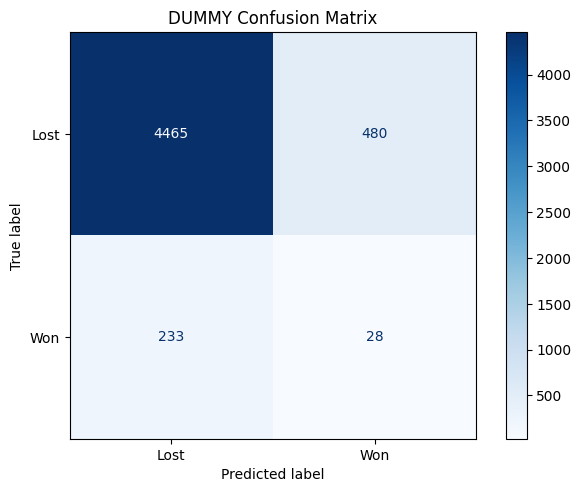

<Figure size 640x480 with 0 Axes>

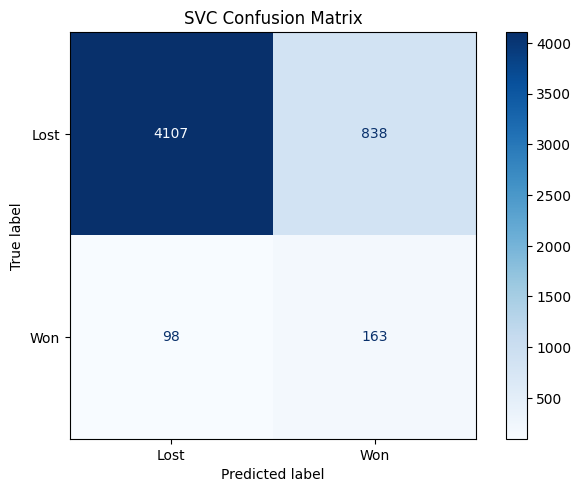

<Figure size 640x480 with 0 Axes>

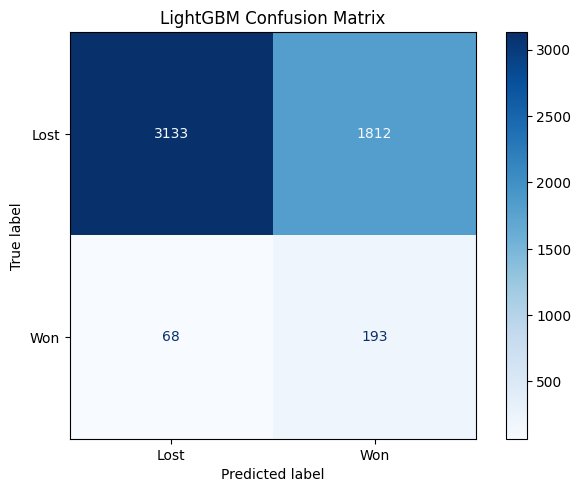

<Figure size 640x480 with 0 Axes>

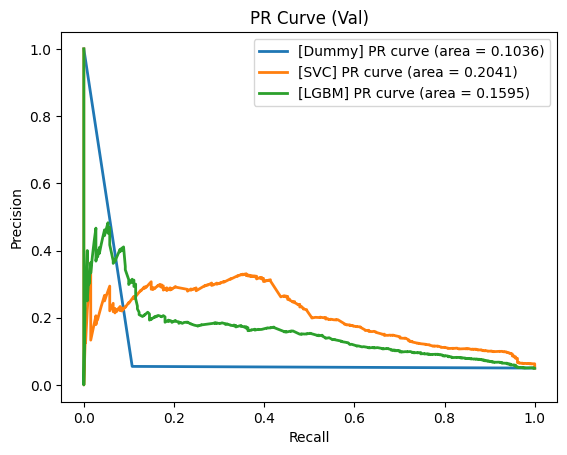

<Figure size 640x480 with 0 Axes>

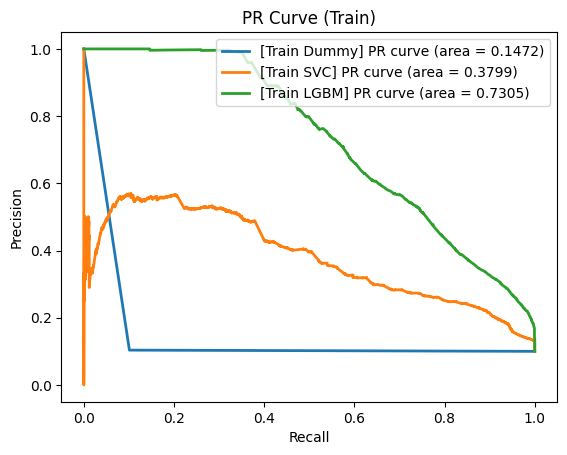

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes, order, title=None, normalize=None):    
    plt.clf()
    if not title:
        title = 'Confusion Matrix, Without Normalization'

    fig, ax = plt.subplots()
    disp = metrics.ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, ax=ax, cmap=plt.cm.Blues, labels=order)
    fig.tight_layout()
    ax.set(title=title, xticklabels=classes, yticklabels=classes)
    plt.show()


def plot_pr_auc(y_true, y_pred, labels=None, title="PR Curve"):    
    plt.clf()
    fig, ax = plt.subplots()
    if labels:
        for label, pred in zip(labels, y_pred):
            precision, recall, _ = metrics.precision_recall_curve(y_true, pred)
            pr_auc = metrics.auc(recall, precision)
            ax.plot(recall, precision, lw=2, label=f'[{label}] PR curve (area = {pr_auc:.4f})')
    else:
        ax.plot(recall, precision, lw=2, label=f'[Model] PR curve (area = {pr_auc:.4f})')
        
    ax.set(xlabel='Recall', ylabel='Precision', title=title)
    ax.legend(loc='upper right')
    plt.show()

test.target = test.target.astype(int)

for ds, label in [(train, 'Train'), (test, 'Test'), (val, 'Val')]:
    for model_name in ['dummy', 'svc', 'lgbm']:
        get_report(get_metrics(ds.target, ds[f'{model_name}_pred'], ds[f'{model_name}_proba']), prefix=f"{label}\t{model_name}:")
        print()

plot_confusion_matrix(val.target.astype(int), val.dummy_pred, 
                      ['Lost', 'Won'], [0, 1], title="DUMMY Confusion Matrix")
plot_confusion_matrix(val.target.astype(int), val.svc_pred, 
                      ['Lost', 'Won'], [0, 1], title="SVC Confusion Matrix")
plot_confusion_matrix(val.target.astype(int), val.lgbm_pred, 
                      ['Lost', 'Won'], [0, 1], title="LightGBM Confusion Matrix")
plot_pr_auc(val.target.astype(int), [val.dummy_proba, val.svc_proba, val.lgbm_proba], 
            labels=['Dummy', 'SVC', 'LGBM'], title='PR Curve (Val)')
plot_pr_auc(train.target.astype(int), [train.dummy_proba, train.svc_proba, train.lgbm_proba], 
            labels=['Train Dummy', 'Train SVC', 'Train LGBM'], title='PR Curve (Train)')


Based on the figures above, the following conclusions can be made about the baseline models. First, there is a clear overfit for both models, as they perform relatively well on the train sets but much less so on the test sets. While this is expected for SVCs that weren't tested against validation sets during training, this is unexpected for the LightGBM (with PR AUC being 0.1 for test but 0.71 for train), whose metric evaluation was conducted on the validation set during testing.

Nevertheless, SVC seems to perform marginally better - recall, which is an important metric in this scenario as we want to minimize false negatives, is significantly higher. SVC is generally better at figuring positive cases while not significantly losing in precision to LightGBM. It is likely that over larger sets of hyperparameters, LightGBM will be able to reduce its overfit and perform better on unseen data.

<Figure size 640x480 with 0 Axes>

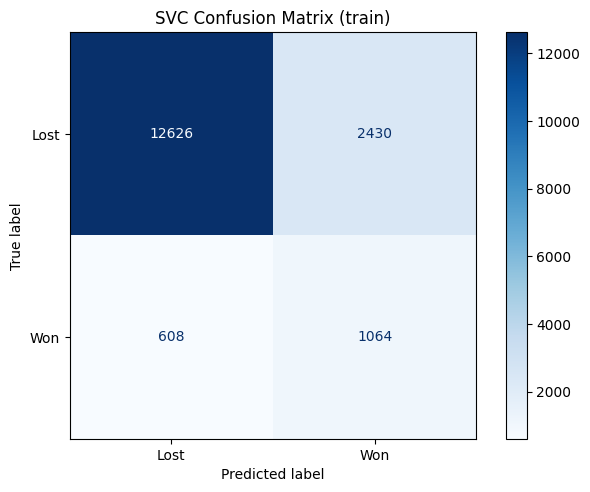

<Figure size 640x480 with 0 Axes>

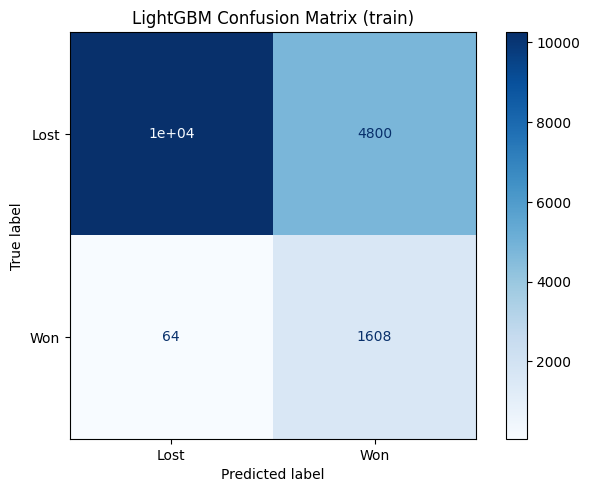

In [39]:
plot_confusion_matrix(train.target.astype(int), train.svc_pred, 
                      ['Lost', 'Won'], [0, 1], title="SVC Confusion Matrix (train)")
plot_confusion_matrix(train.target.astype(int), train.lgbm_pred, 
                      ['Lost', 'Won'], [0, 1], title="LightGBM Confusion Matrix (train)")

## Checkpoint

The code cell below saves all the models with a unique timestamp so that it could be retrieved in the future.

In [31]:
# save all models

models_dir = 'models'
Path(models_dir).mkdir(parents=True, exist_ok=True)

def save_all_models_and_pred(models, labels, train_df, test_df, val_df, svc_study_df, lgbm_study_df):
    model_path = f"{models_dir}/{int(time.time())}"
    Path(model_path).mkdir(parents=True)

    for m, l in zip(models, labels):
        with open(f'{model_path}/{l}_model.pkl', 'wb') as f:
            pickle.dump(m, f)
    with open(f'{model_path}/all_feature_names.pkl', 'wb') as f:
        pickle.dump(train_columns, f)
    train_df.to_csv(f'{model_path}/train.csv')
    test_df.to_csv(f'{model_path}/test.csv')
    val_df.to_csv(f'{model_path}/val.csv')
    svc_study_df.to_csv(f'{model_path}/svc_study.csv', index=False)
    lgbm_study_df.to_csv(f'{model_path}/lgbm_study.csv', index=False)


models = [dummy, svc, lgbm, scaler]
labels = ['dummy', 'svc', 'lgbm', 'scaler']
save_all_models_and_pred(models, labels, train, test, val, svc_trials_df, lgbm_trials_df)

In [37]:
print(', '.join([x for x in svc.feature_names_in_]))

current_duration, n__fc__rw7, mean_owner_included__tc__rw30, mean_owner_included__me__rw30, mean_duration_in__me__rw90, mean_owner_included__fc__rw90, mean_owner_included__me__rw90, n__fc__x, n__tc__x, mean_owner_included__tc__x, mean_n_recipients__fc__x


In [38]:
print(', '.join([x for x in lgbm.feature_name_]))

current_duration, n__tc, n__me, n__tc__rw7, mean_owner_included__me__rw7, mean_owner_included__tc__rw30, mean_owner_included__me__rw30, mean_n_recipients__tc__rw30, n__tc__rw90, mean_owner_included__fc__rw90, mean_owner_included__me__x, mean_n_recipients__me__x
